In [319]:
import requests
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns



#from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
pd.set_option('display.max_rows', 3000)


# Loading Dataset

In [320]:
confirmed= pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths= pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoverd=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [321]:
confirmed.head()
deaths.head()
recoverd.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  6/8/20  6/9/20  6/10/20  6/11/20  6/12/20  \
0        0        0        0  ...    2171    2651     3013     3326     3928   
1        0        0        0  ...     945     960      980     1001     1034   
2        0        0        0  ...    6799    6951     7074     7255     7322   
3        0        0        0  ...     751     757      759      780      781   
4        0        0        0  ...      38      38       40       41       42   

   6/13/20  6/14/20  6/15/20  6/16/20  6/17/20  
0     4201     4725     5164     5508     6158  
1     1039     1044     1055     1064     1077  
2     7420     7606     7735     7842     7943  
3      781      781      789      789      791  
4       61       61       64       64       64  

[5 rows x 152 columns]

We have data regarding number of confirmed cases, deaths and recovered cases from Jan 22 till May31 

In [322]:
confirmed.shape
deaths.shape
recoverd.shape

(253, 152)

# Data Preprocessing

Unpivoting the data using dates as variables and then merging confirmed, deaths and recovered tables 
Number of countries in recoverd table are less than those in confirmed and deaths table. Assuming that the missing countries have zero recovery cases and hence replacing null values with"0". 

In [323]:
confirmed_df = confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=confirmed.columns[4:], var_name='Date', value_name='Confirmed')

deaths_df = deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=confirmed.columns[4:], var_name='Date', value_name='Deaths')
recovered_df =recoverd.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=confirmed.columns[4:], var_name='Date', value_name='Recovered')

In [324]:
recovered_df.head()

Province/State Country/Region      Lat     Long     Date  Recovered
0            NaN    Afghanistan  33.0000  65.0000  1/22/20          0
1            NaN        Albania  41.1533  20.1683  1/22/20          0
2            NaN        Algeria  28.0339   1.6596  1/22/20          0
3            NaN        Andorra  42.5063   1.5218  1/22/20          0
4            NaN         Angola -11.2027  17.8739  1/22/20          0

In [325]:
World_Data = pd.merge (confirmed_df,deaths_df,how='left', on= ['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'] )
World_Data = pd.merge (World_Data,recovered_df,how='left', on= ['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'] )

In [326]:
print(World_Data.shape)
World_Data.head()

(39368, 8)


Province/State Country/Region      Lat     Long     Date  Confirmed  Deaths  \
0            NaN    Afghanistan  33.0000  65.0000  1/22/20          0       0   
1            NaN        Albania  41.1533  20.1683  1/22/20          0       0   
2            NaN        Algeria  28.0339   1.6596  1/22/20          0       0   
3            NaN        Andorra  42.5063   1.5218  1/22/20          0       0   
4            NaN         Angola -11.2027  17.8739  1/22/20          0       0   

   Recovered  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [327]:
World_Data.isna().sum()

Province/State    27380
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered          2516
dtype: int64

In [328]:
World_Data[World_Data['Recovered'].isna()]['Country/Region'].value_counts()

Canada         2072
Syria           148
Mozambique      148
Timor-Leste     148
Name: Country/Region, dtype: int64

High number of missing values for Canada's recovery data are observed. 

In [329]:
Null_df = World_Data[World_Data['Recovered'].isna()].groupby(['Date','Country/Region'])

In [330]:
World_Data=World_Data.fillna(0)

#World_Data=World_Data.drop(columns=['Province/State'])
World_Data.rename(columns={'Country/Region':'Country'},inplace=True)

In [331]:
World_Data.isna().sum()

Province/State    0
Country           0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
dtype: int64

In [332]:
print(World_Data.shape)
World_Data.head()


(39368, 8)


Province/State      Country      Lat     Long     Date  Confirmed  Deaths  \
0              0  Afghanistan  33.0000  65.0000  1/22/20          0       0   
1              0      Albania  41.1533  20.1683  1/22/20          0       0   
2              0      Algeria  28.0339   1.6596  1/22/20          0       0   
3              0      Andorra  42.5063   1.5218  1/22/20          0       0   
4              0       Angola -11.2027  17.8739  1/22/20          0       0   

   Recovered  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [333]:
World_Data['Recovered'] = World_Data['Recovered'].astype('int')
World_Data['Deaths'] = World_Data['Deaths'].astype('int')

In [334]:
World_Data.head()

Province/State      Country      Lat     Long     Date  Confirmed  Deaths  \
0              0  Afghanistan  33.0000  65.0000  1/22/20          0       0   
1              0      Albania  41.1533  20.1683  1/22/20          0       0   
2              0      Algeria  28.0339   1.6596  1/22/20          0       0   
3              0      Andorra  42.5063   1.5218  1/22/20          0       0   
4              0       Angola -11.2027  17.8739  1/22/20          0       0   

   Recovered  
0          0  
1          0  
2          0  
3          0  
4          0

In [335]:
World_Data[World_Data['Country']=='India'].tail()

Province/State Country   Lat  Long     Date  Confirmed  Deaths  \
38169              0   India  21.0  78.0  6/13/20     320922    9195   
38435              0   India  21.0  78.0  6/14/20     332424    9520   
38701              0   India  21.0  78.0  6/15/20     343091    9900   
38967              0   India  21.0  78.0  6/16/20     354065   11903   
39233              0   India  21.0  78.0  6/17/20     366946   12237   

       Recovered  
38169     162379  
38435     169798  
38701     180013  
38967     186935  
39233     194325

In [336]:
World_Data.to_csv('Covid_World_Data.csv',index= False)

In [337]:
World_Data['Date']=pd.to_datetime(World_Data['Date'])
World_Data.head()

Province/State      Country      Lat     Long       Date  Confirmed  Deaths  \
0              0  Afghanistan  33.0000  65.0000 2020-01-22          0       0   
1              0      Albania  41.1533  20.1683 2020-01-22          0       0   
2              0      Algeria  28.0339   1.6596 2020-01-22          0       0   
3              0      Andorra  42.5063   1.5218 2020-01-22          0       0   
4              0       Angola -11.2027  17.8739 2020-01-22          0       0   

   Recovered  
0          0  
1          0  
2          0  
3          0  
4          0

In [338]:
World_Data.loc[World_Data['Country']=='Congo (Brazzaville)','Country']='DR Congo'

World_Data.loc[World_Data['Country']=='Congo (Kinshasa)','Country']='DR Congo'
World_Data.loc[World_Data['Country']=='Taiwan*','Country']='Taiwan'

Multiple entries for countries are merged to get cumulative data 


In [339]:
#World_Data['Active']= World_Data['Confirmed']-World_Data['Deaths']-World_Data['Recovered']
World_Data = World_Data.groupby(['Date', 'Country'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
World_Data.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Date      Country  Confirmed  Deaths  Recovered
0 2020-01-22  Afghanistan          0       0          0
1 2020-01-22      Albania          0       0          0
2 2020-01-22      Algeria          0       0          0
3 2020-01-22      Andorra          0       0          0
4 2020-01-22       Angola          0       0          0

Checking if the data presented here is valid or not. With time, number of confirmed or deaths or recoveries should be increasing but in our dataset its contrary. lets try to manipulate data 

In [369]:
d=World_Data.groupby(['Country', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()  
pd.set_option('display.max_rows', 3000)
#FIrst row
d.loc[0,'Confirmed_n']= d.loc[0,'Confirmed']
d.loc[0,'Deaths_n']= d.loc[0,'Deaths']
d.loc[0,'Recovered_n']= d.loc[0,'Recovered']
for i in range(1,len(d)):
    if d.loc[i,'Country']!= d.loc[i-1,'Country']:
        d.loc[i,'Confirmed_n']= d.loc[i,'Confirmed']
        d.loc[i,'Deaths_n']= d.loc[i,'Deaths']
        d.loc[i,'Recovered_n']= d.loc[i,'Recovered']
    else:
        if d.loc[i,'Confirmed'] < d.loc[i-1,'Confirmed']:
            d.loc[i,'Confirmed']=d.loc[i-1,'Confirmed']
        if d.loc[i,'Deaths'] < d.loc[i-1,'Deaths']:
            d.loc[i,'Deaths']=d.loc[i-1,'Deaths']
        if d.loc[i,'Recovered'] < d.loc[i-1,'Recovered']:
            d.loc[i,'Recovered']=d.loc[i-1,'Recovered']
        d.loc[i,'Confirmed_n']= d.loc[i,'Confirmed']-d.loc[i-1,'Confirmed']
        d.loc[i,'Deaths_n']= d.loc[i,'Deaths']-d.loc[i-1,'Deaths']
        d.loc[i,'Recovered_n']= d.loc[i,'Recovered']-d.loc[i-1,'Recovered']
    #d.loc[i,'Con_y']= d.loc[i-1,'Confirmed']
for i in range(len(d)):
    if d.loc[i,'Confirmed']==0:
        d.loc[i,'Deathrate']=0
        d.loc[i,'Recoveryrate']=0
    else:
        d.loc[i,'Deathrate']= round(d.loc[i,'Deaths']/d.loc[i,'Confirmed']*100,2)
        d.loc[i,'Recoveryrate']= round(d.loc[i,'Recovered']/d.loc[i,'Confirmed']*100,2)
d.tail(300)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  \
27376     Yemen 2020-06-14        728     164         53         23.0   
27377     Yemen 2020-06-15        844     208         79        116.0   
27378     Yemen 2020-06-16        885     214         91         41.0   
27379     Yemen 2020-06-17        902     244        271         17.0   
27380    Zambia 2020-01-22          0       0          0          0.0   
27381    Zambia 2020-01-23          0       0          0          0.0   
27382    Zambia 2020-01-24          0       0          0          0.0   
27383    Zambia 2020-01-25          0       0          0          0.0   
27384    Zambia 2020-01-26          0       0          0          0.0   
27385    Zambia 2020-01-27          0       0          0          0.0   
27386    Zambia 2020-01-28          0       0          0          0.0   
27387    Zambia 2020-01-29          0       0          0          0.0   
27388    Zambia 2020-01-30          0       0          0          0.0   
27389    Zambia 2020-01-31          0       0          0          0.0   
27390    Zambia 2020-02-01          0       0          0          0.0   
27391    Zambia 2020-02-02          0       0          0          0.0   
27392    Zambia 2020-02-03          0       0          0          0.0   
27393    Zambia 2020-02-04          0       0          0          0.0   
27394    Zambia 2020-02-05          0       0          0          0.0   
27395    Zambia 2020-02-06          0       0          0          0.0   
27396    Zambia 2020-02-07          0       0          0          0.0   
27397    Zambia 2020-02-08          0       0          0          0.0   
27398    Zambia 2020-02-09          0       0          0          0.0   
27399    Zambia 2020-02-10          0       0          0          0.0   
27400    Zambia 2020-02-11          0       0          0          0.0   
27401    Zambia 2020-02-12          0       0          0          0.0   
27402    Zambia 2020-02-13          0       0          0          0.0   
27403    Zambia 2020-02-14          0       0          0          0.0   
27404    Zambia 2020-02-15          0       0          0          0.0   
27405    Zambia 2020-02-16          0       0          0          0.0   
27406    Zambia 2020-02-17          0       0          0          0.0   
27407    Zambia 2020-02-18          0       0          0          0.0   
27408    Zambia 2020-02-19          0       0          0          0.0   
27409    Zambia 2020-02-20          0       0          0          0.0   
27410    Zambia 2020-02-21          0       0          0          0.0   
27411    Zambia 2020-02-22          0       0          0          0.0   
27412    Zambia 2020-02-23          0       0          0          0.0   
27413    Zambia 2020-02-24          0       0          0          0.0   
27414    Zambia 2020-02-25          0       0          0          0.0   
27415    Zambia 2020-02-26          0       0          0          0.0   
27416    Zambia 2020-02-27          0       0          0          0.0   
27417    Zambia 2020-02-28          0       0          0          0.0   
27418    Zambia 2020-02-29          0       0          0          0.0   
27419    Zambia 2020-03-01          0       0          0          0.0   
27420    Zambia 2020-03-02          0       0          0          0.0   
27421    Zambia 2020-03-03          0       0          0          0.0   
27422    Zambia 2020-03-04          0       0          0          0.0   
27423    Zambia 2020-03-05          0       0          0          0.0   
27424    Zambia 2020-03-06          0       0          0          0.0   
27425    Zambia 2020-03-07          0       0          0          0.0   
27426    Zambia 2020-03-08          0       0          0          0.0   
27427    Zambia 2020-03-09          0       0          0          0.0   
27428    Zambia 2020-03-10          0       0          0          0.0   
27429    Zambia 2020-03-11          0       0          0          

In [370]:
d[d['Country']=='China']['Recovered'].is_monotonic

True

In [371]:
d[d['Country']=='China']

Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  Deaths_n  \
5328   China 2020-01-22        548      17         28        548.0      17.0   
5329   China 2020-01-23        643      18         30         95.0       1.0   
5330   China 2020-01-24        920      26         36        277.0       8.0   
5331   China 2020-01-25       1406      42         39        486.0      16.0   
5332   China 2020-01-26       2075      56         49        669.0      14.0   
5333   China 2020-01-27       2877      82         58        802.0      26.0   
5334   China 2020-01-28       5509     131        101       2632.0      49.0   
5335   China 2020-01-29       6087     133        120        578.0       2.0   
5336   China 2020-01-30       8141     171        135       2054.0      38.0   
5337   China 2020-01-31       9802     213        214       1661.0      42.0   
5338   China 2020-02-01      11891     259        275       2089.0      46.0   
5339   China 2020-02-02      16630     361        463       4739.0     102.0   
5340   China 2020-02-03      19716     425        614       3086.0      64.0   
5341   China 2020-02-04      23707     491        843       3991.0      66.0   
5342   China 2020-02-05      27440     563       1115       3733.0      72.0   
5343   China 2020-02-06      30587     633       1477       3147.0      70.0   
5344   China 2020-02-07      34110     718       1999       3523.0      85.0   
5345   China 2020-02-08      36814     805       2596       2704.0      87.0   
5346   China 2020-02-09      39829     905       3219       3015.0     100.0   
5347   China 2020-02-10      42354    1012       3918       2525.0     107.0   
5348   China 2020-02-11      44386    1112       4636       2032.0     100.0   
5349   China 2020-02-12      44759    1117       5082        373.0       5.0   
5350   China 2020-02-13      59895    1369       6217      15136.0     252.0   
5351   China 2020-02-14      66358    1521       7977       6463.0     152.0   
5352   China 2020-02-15      68413    1663       9298       2055.0     142.0   
5353   China 2020-02-16      70513    1766      10755       2100.0     103.0   
5354   China 2020-02-17      72434    1864      12462       1921.0      98.0   
5355   China 2020-02-18      74211    2003      14206       1777.0     139.0   
5356   China 2020-02-19      74619    2116      15962        408.0     113.0   
5357   China 2020-02-20      75077    2238      18014        458.0     122.0   
5358   China 2020-02-21      75550    2238      18704        473.0       0.0   
5359   China 2020-02-22      77001    2443      22699       1451.0     205.0   
5360   China 2020-02-23      77022    2445      23187         21.0       2.0   
5361   China 2020-02-24      77241    2595      25015        219.0     150.0   
5362   China 2020-02-25      77754    2665      27676        513.0      70.0   
5363   China 2020-02-26      78166    2717      30084        412.0      52.0   
5364   China 2020-02-27      78600    2746      32930        434.0      29.0   
5365   China 2020-02-28      78928    2790      36329        328.0      44.0   
5366   China 2020-02-29      79356    2837      39320        428.0      47.0   
5367   China 2020-03-01      79932    2872      42162        576.0      35.0   
5368   China 2020-03-02      80136    2914      44854        204.0      42.0   
5369   China 2020-03-03      80261    2947      47450        125.0      33.0   
5370   China 2020-03-04      80386    2983      50001        125.0      36.0   
5371   China 2020-03-05      80537    3015      52292        151.0      32.0   
5372   China 2020-03-06      80690    3044      53944        153.0      29.0   
5373   China 2020-03-07      80770    3072      55539         80.0      28.0   
5374   China 2020-03-08      80823    3100      57388         53.0      28.0   
5375   China 2020-03-09      80860    3123      58804         37.0      23.0   
5376   China 2020-03-10      80887    3139      60181         27.0      16.0   
5377 

In [372]:

d.isna().sum()

Country         0
Date            0
Confirmed       0
Deaths          0
Recovered       0
Confirmed_n     0
Deaths_n        0
Recovered_n     0
Deathrate       0
Recoveryrate    0
dtype: int64

After eliminating mistakes like reduced confirmed cases or deaths or recoveries with time. If confirmed cases on previous day are more than today, then set today's data equal to yesterday's

In [373]:
#World_Data= World_Data.join(World.set_index(['Date','Country'])[['Confirmed_n','Active_n','Deaths_n','Recovered_n']],on=['Date','Country'],how='left')
#World_Data['Confirmed_n']=World_Data['Confirmed_n'].fillna(World_Data['Confirmed'])
#World_Data['Active_n']=World_Data['Active_n'].fillna(World_Data['Active'])
#World_Data['Recovered_n']=World_Data['Recovered_n'].fillna(World_Data['Recovered'])
#World_Data['Deaths_n']=World_Data['Deaths_n'].fillna(World_Data['Deaths'])
#World_Data[World_Data['Date']=='2020-01-22'].head()
World_Data = d.copy()



In [374]:
World_Data['Active']= World_Data['Confirmed']-World_Data['Deaths']-World_Data['Recovered']
World_Data['Active_n']= World_Data['Confirmed_n']-World_Data['Deaths_n']-World_Data['Recovered_n']
World_Data['Confirmed_n']=World_Data['Confirmed_n'].astype(int)
World_Data['Deaths_n']=World_Data['Deaths_n'].astype(int)
World_Data['Recovered_n']=World_Data['Recovered_n'].astype(int)
World_Data['Active_n']=World_Data['Active_n'].astype(int)
print(str(World_Data[World_Data['Confirmed_n']<0]['Date'].count())+' days with negative Confirmed cases found')
print(str(World_Data[World_Data['Deaths_n']<0]['Date'].count())+' days with negative Death cases found')
print(str(World_Data[World_Data['Recovered_n']<0]['Date'].count())+' days with negative Recovered cases found')
print(str(World_Data[World_Data['Active_n']<0]['Date'].count())+' days with negative Active cases found')
World_Data.head()

0 days with negative Confirmed cases found
0 days with negative Death cases found
0 days with negative Recovered cases found
3824 days with negative Active cases found


Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  \
0  Afghanistan 2020-01-22          0       0          0            0   
1  Afghanistan 2020-01-23          0       0          0            0   
2  Afghanistan 2020-01-24          0       0          0            0   
3  Afghanistan 2020-01-25          0       0          0            0   
4  Afghanistan 2020-01-26          0       0          0            0   

   Deaths_n  Recovered_n  Deathrate  Recoveryrate  Active  Active_n  
0         0            0        0.0           0.0       0         0  
1         0            0        0.0           0.0       0         0  
2         0            0        0.0           0.0       0         0  
3         0            0        0.0           0.0       0         0  
4         0            0        0.0           0.0       0         0

In [375]:
#Bar plot to check scenario af confirmed cases 
from datetime import date
import datetime
Previous_Date = date.today() - datetime.timedelta(days=1)

print('Information as on '+ str(Previous_Date))
Data_recent = World_Data[World_Data['Date']==max(World_Data['Date'])]

Data_recent.head()

Information as on 2020-06-17


Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  \
147  Afghanistan 2020-06-17      26874     504       6158          564   
295      Albania 2020-06-17       1722      38       1077           50   
443      Algeria 2020-06-17      11268     799       7943          121   
591      Andorra 2020-06-17        854      52        791            0   
739       Angola 2020-06-17        155       7         64            7   

     Deaths_n  Recovered_n  Deathrate  Recoveryrate  Active  Active_n  
147        13          650       1.88         22.91   20212       -99  
295         1           13       2.21         62.54     607        36  
443        11          101       7.09         70.49    2526         9  
591         0            2       6.09         92.62      11        -2  
739         1            0       4.52         41.29      84         6

In [376]:
Total=Data_recent.groupby(['Date'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
Total=Total.melt(id_vars=[],value_vars=Total.columns[0:], var_name='Variable', value_name='Values')
Total=Total.drop([0])
Total


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Variable   Values
1  Confirmed  8349950
2     Deaths   450576
3  Recovered  4010418
4     Active  3888956

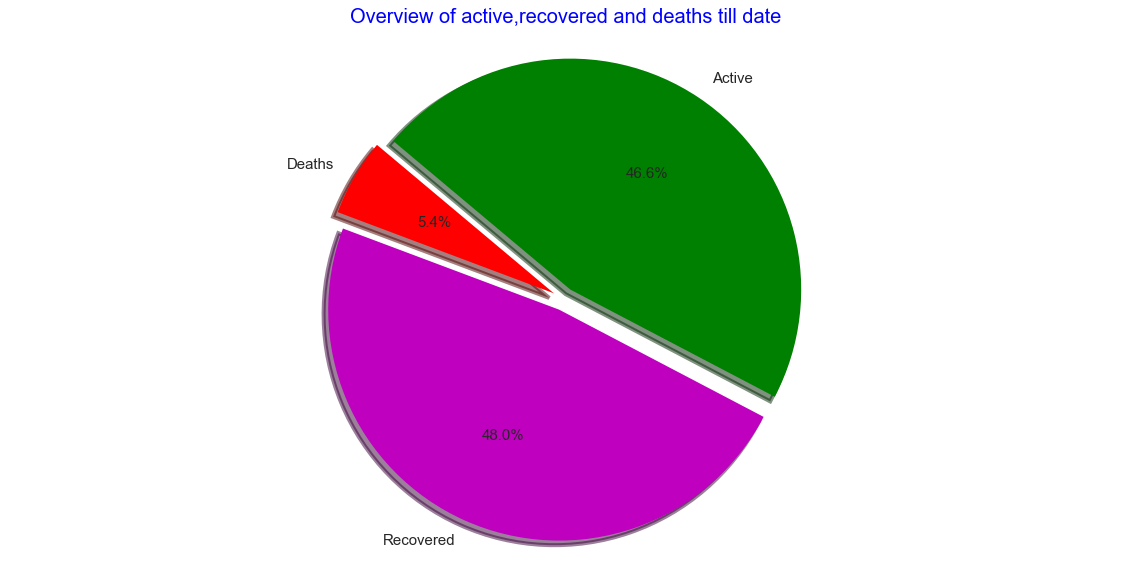

In [377]:
size=Total['Values'][1:]
label=Total['Variable'][1:]
color=['r','m','g']
plt.figure(figsize=(20,10))
plt.pie(size, explode=[0.05,0.05,0.05], labels=label,colors=color,
autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': 15},wedgeprops={'linewidth': 4})
plt.title('Overview of active,recovered and deaths till date',fontsize=20,color='b')
plt.axis('equal')
plt.show()


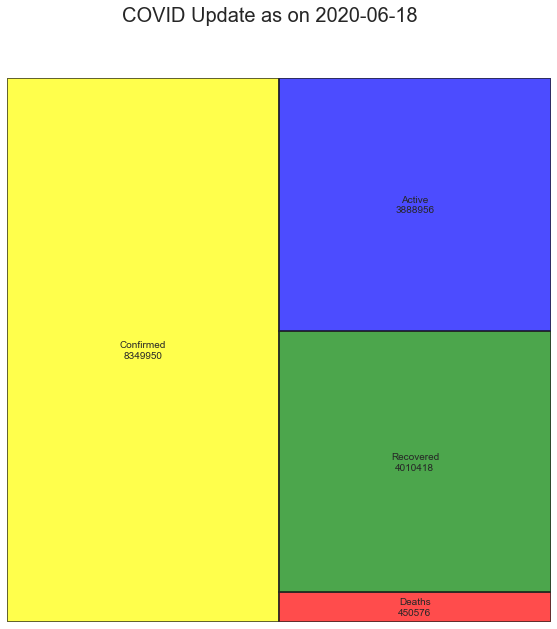

In [378]:
!pip install squarify
import squarify
labels=[]
for i,j in zip(Total['Variable'],Total['Values']):
    k=str(i)+'\n'+str(j)
    labels.append(k)
fig = plt.figure(figsize=(10, 10))
fig.suptitle('COVID Update as on '+str(date.today()), fontsize=20)
ax = fig.add_subplot(111, aspect="equal")
ax=squarify.plot(sizes=Total['Values'], label=labels,
              color=['yellow','red','green','blue'], alpha=0.7, bar_kwargs=dict(linewidth=2, edgecolor="#222222"))
plt.axis('off')
plt.rc('font', size=15)
plt.show()


In [379]:
timed_data = World_Data.groupby('Date').sum().reset_index()
timed_data['Deathrate']=timed_data['Deaths']/timed_data['Confirmed']*100
timed_data['Activerate']=timed_data['Active']/timed_data['Confirmed']*100
timed_data['Recoveryrate']=timed_data['Recovered']/timed_data['Confirmed']*100
timed_data.head()

Date  Confirmed  Deaths  Recovered  Confirmed_n  Deaths_n  \
0 2020-01-22        555      17         28          555        17   
1 2020-01-23        654      18         30           99         1   
2 2020-01-24        941      26         36          287         8   
3 2020-01-25       1434      42         39          493        16   
4 2020-01-26       2118      56         52          684        14   

   Recovered_n  Deathrate  Recoveryrate  Active  Active_n  Activerate  
0           28   3.063063      5.045045     510       510   91.891892  
1            2   2.752294      4.587156     606        96   92.660550  
2            6   2.763018      3.825717     879       273   93.411265  
3            3   2.928870      2.719665    1353       474   94.351464  
4           13   2.644004      2.455146    2010       657   94.900850

Text(0.02, 0.7, 'Statistics from Jan22-2020 to Jun17-2020\nTotal Confirmed : 8349950\nTotal Deaths : 450576\nTotal Active : 48.029245684105895\nTotal Recoveries : 4010418\nMortality rate : 5.4%\nNew cases in the last 5 days:\nConfirmed : 705690\nDeaths : 23178\nNew cases in the last one day :\nConfirmed : 176010\nDeaths : 5274\n')

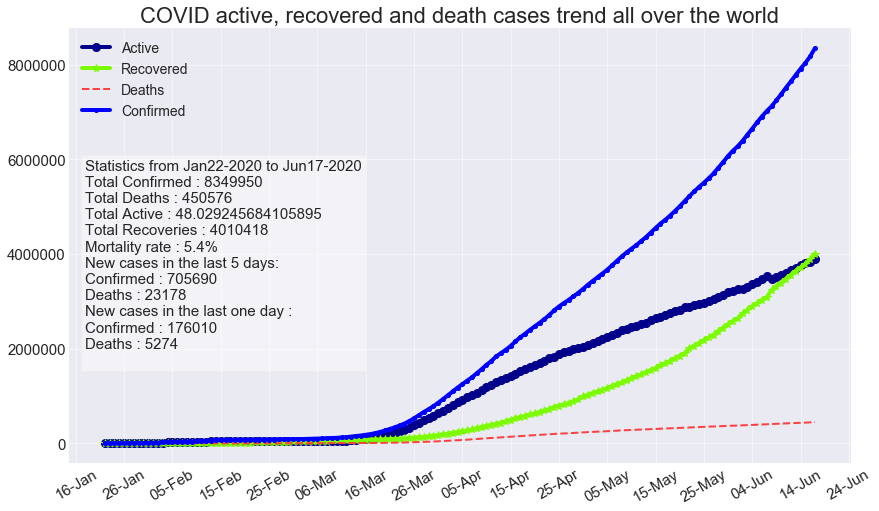

In [380]:
f,ax= plt.subplots(figsize=(14,8))
import matplotlib.ticker as ticker
#plt.figure(figsize=(14,8))
plt.style.use('seaborn-darkgrid')

plt.plot( 'Date','Active', data=timed_data, marker='o', color='#00008B',markersize=8, linewidth=4)
plt.plot( 'Date','Recovered', data=timed_data, marker='*', color='#7CFC00',markersize=8, linewidth=4)
plt.plot('Date','Deaths', data=timed_data, marker=' ', color='#FF4040', markersize=8,linewidth=2, linestyle='dashed')
plt.plot( 'Date','Confirmed', data=timed_data, marker='o', color='blue',markersize=4, linewidth=4)
plt.legend(fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=30)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.title('COVID active, recovered and death cases trend all over the world',fontsize=22)
text = "Statistics from "+str(min(timed_data['Date']).strftime('%b%d-%Y'))+" to "+str(max(timed_data['Date']).strftime('%b%d-%Y'))+"\n"
text +="Total Confirmed : "+str(timed_data.iloc[-1,1])+"\n"
text +="Total Deaths : "+str(timed_data.iloc[-1,2])+"\n"
text +="Total Active : "+str(timed_data.iloc[-1,8])+"\n"
text +="Total Recoveries : "+str(timed_data[timed_data['Date']==max(timed_data['Date'])].iloc[-1,3])+"\n"
text +="Mortality rate : "+ str(round(timed_data.iloc[-1,2]/timed_data.iloc[-1,1]*100,2))+"%"+"\n"
text +="New cases in the last 5 days:\n"
text +="Confirmed : " + str(timed_data.iloc[-1,1] - timed_data.iloc[-6,1])+"\n"
text +="Deaths : " + str(timed_data.iloc[-1,2] - timed_data.iloc[-6,2])+"\n"
text +="New cases in the last one day :\n"
text +="Confirmed : " + str(timed_data.iloc[-1,1] - timed_data.iloc[-2,1])+"\n"
text +="Deaths : " + str(timed_data.iloc[-1,2] - timed_data.iloc[-2,2])+"\n"
    
plt.text(0.02, 0.70, text, fontsize=15, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))



Text(0.5, 1.0, 'Recovery rate trend all over the world ')

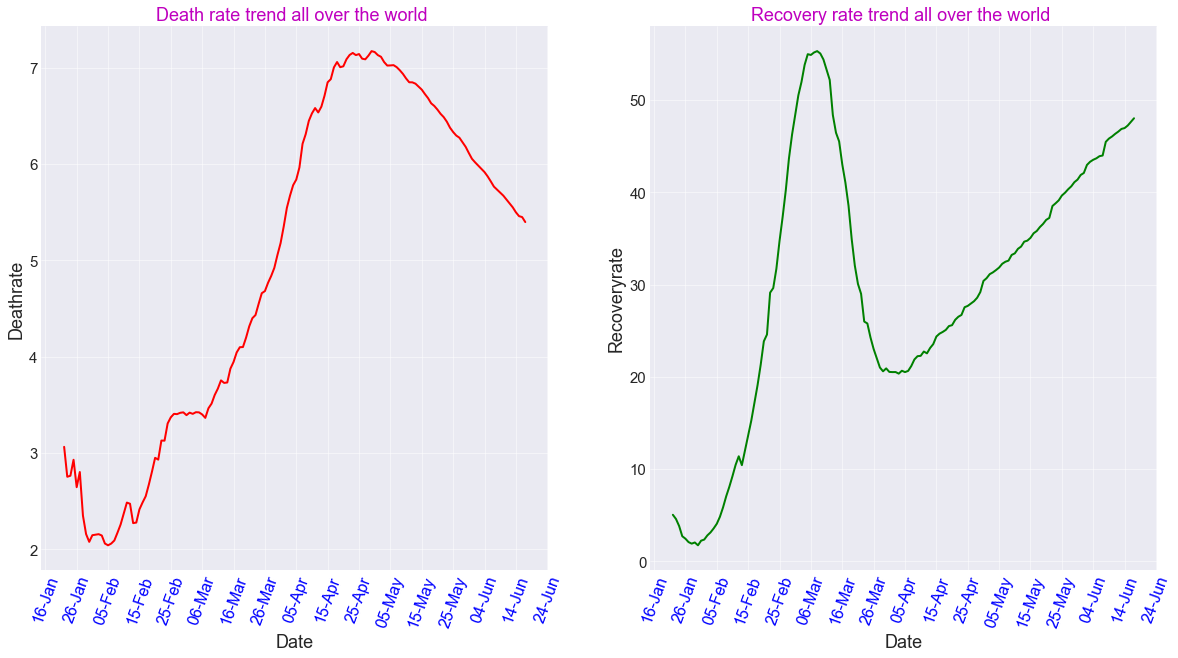

In [382]:
plt.figure(figsize=(20,10))
plt.style.use('seaborn-darkgrid')
plt.subplot(1, 2, 1)
ax1=sns.lineplot(x='Date',y='Deathrate',data=timed_data,color='red')
ax1.set_title('Death rate trend all over the world ',fontsize=18,color='m')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(fontsize=16,color='blue')
plt.xticks(rotation=70)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.subplot(1, 2, 2)
ax2=sns.lineplot(x='Date',y='Recoveryrate',data=timed_data,color='green')
plt.xticks(rotation=70)
plt.xticks(fontsize=16,color='blue')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax2.set_title('Recovery rate trend all over the world ',fontsize=18,color='m')

in april, both death and recovery rates have started increasing but in first week of may there is a reduction in death rate..

In [383]:
import matplotlib.ticker as ticker
def barplot(data,col,plot_type,color):
#plt.figure(figsize=(14,8))
    f,ax= plt.subplots(figsize=(14,8))
    plt.style.use(plot_type)

    plt.bar( 'Date',col, data=data, color=color, linewidth=4)
    plt.plot('Date',col, data=data, color='black', linewidth=2)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    plt.grid(linewidth=0.5,alpha=0.5)
    plt.title('COVID new '+str(col)+' cases trend all over the world',fontsize=22)

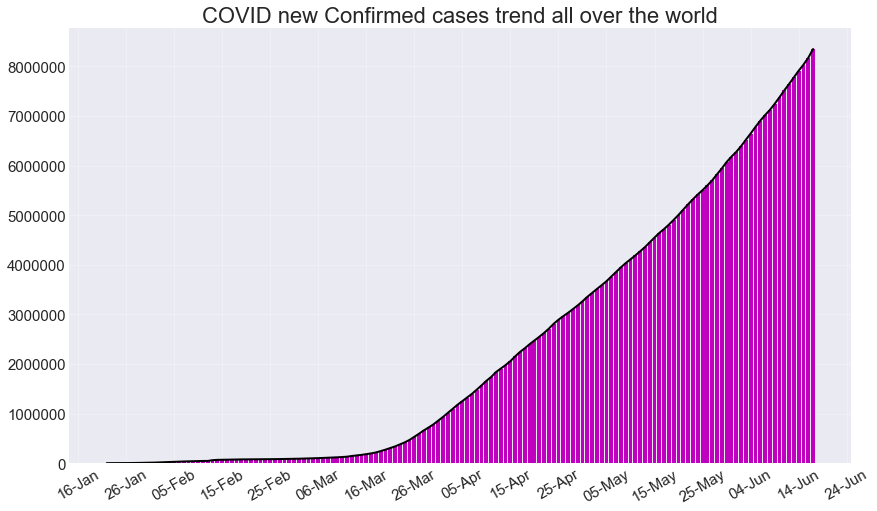

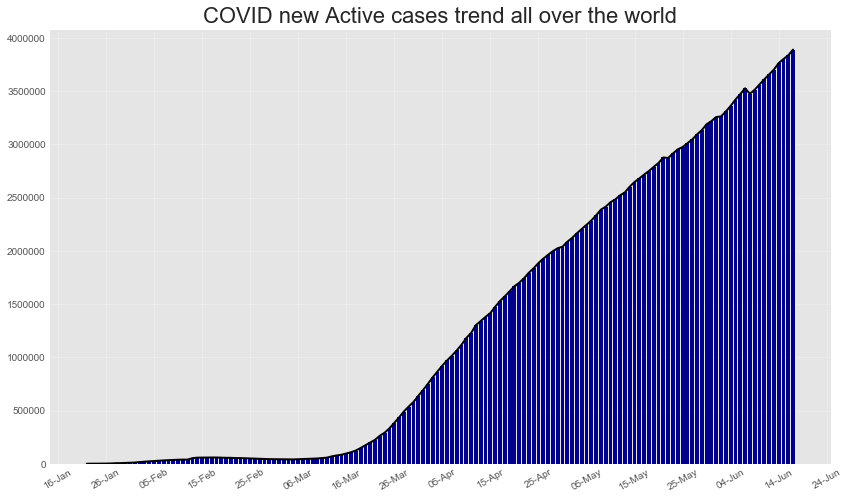

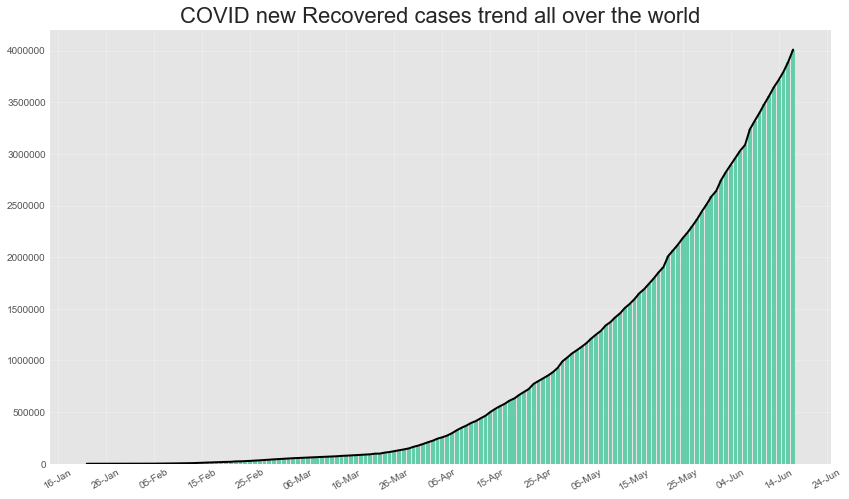

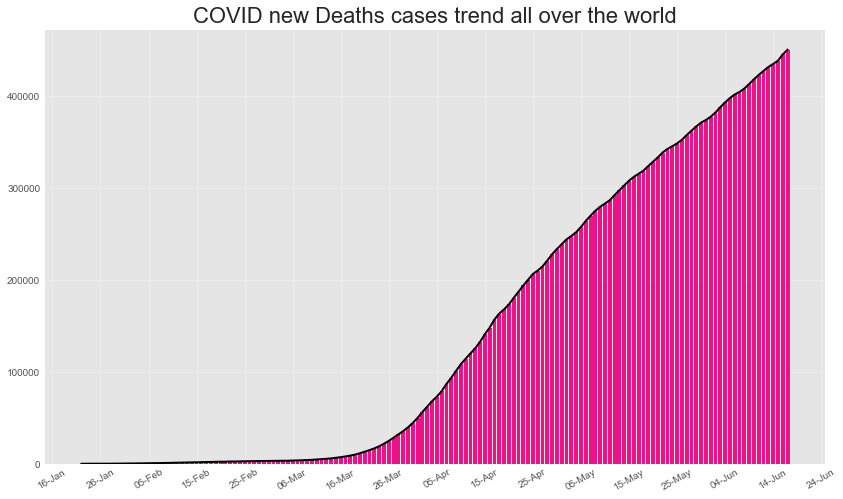

In [384]:
barplot(timed_data,'Confirmed','ggplot','m')
barplot(timed_data,'Active','ggplot','#00008B')
barplot(timed_data,'Recovered','ggplot','#66CDAA')
barplot(timed_data,'Deaths','ggplot','#EE1289')

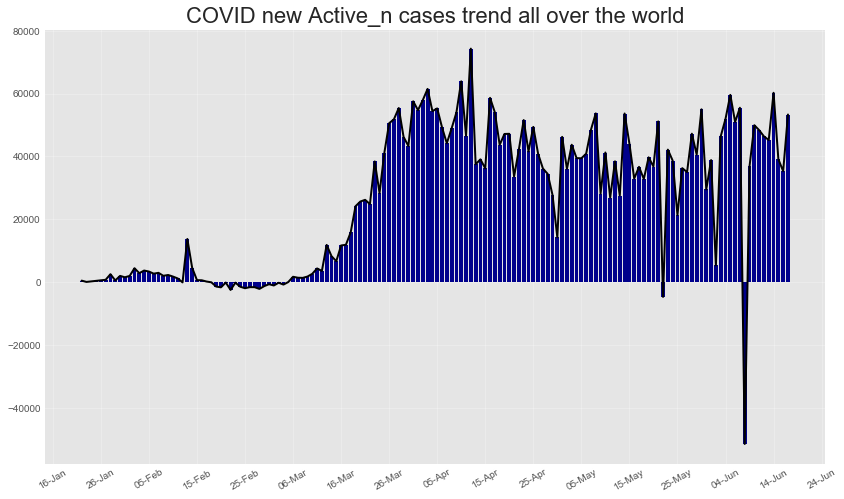

In [385]:
barplot(timed_data,'Active_n','ggplot','#00008B')

In [386]:
#Huge reduction in active cases on 8th june is observed --This is due to missing recovery information in 'Brazil' which shows around 1 lakh recoveries in one day
print(timed_data[timed_data['Date']=='2020-06-08'])
World_Data[(World_Data['Date']=='2020-06-08')&(World_Data['Country']=='Brazil')]

          Date  Confirmed  Deaths  Recovered  Confirmed_n  Deaths_n  \
138 2020-06-08    7120423  408217    3238012       103378      3744   

     Recovered_n  Deathrate  Recoveryrate   Active  Active_n  Activerate  
138       151081   5.733044     45.474995  3474194    -51447   48.791961  


Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  Deaths_n  \
3542  Brazil 2020-06-08     707412   37134     378257        15654       679   

      Recovered_n  Deathrate  Recoveryrate  Active  Active_n  
3542        94305       5.25         53.47  292021    -79330

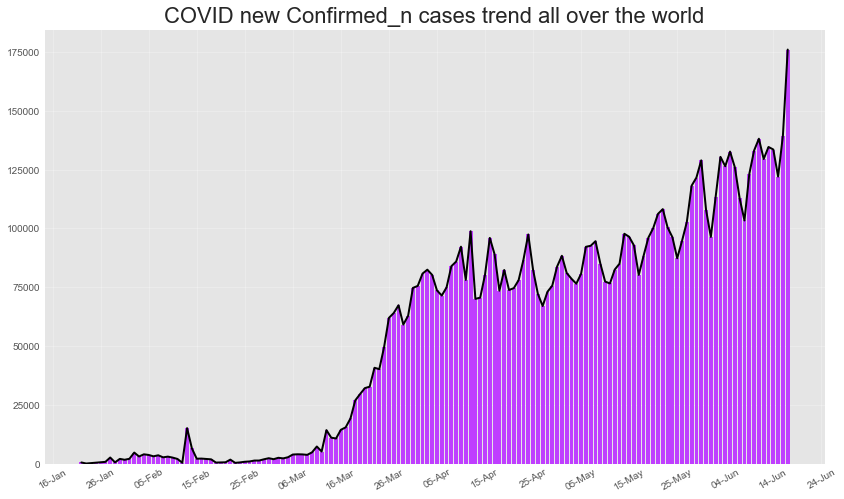

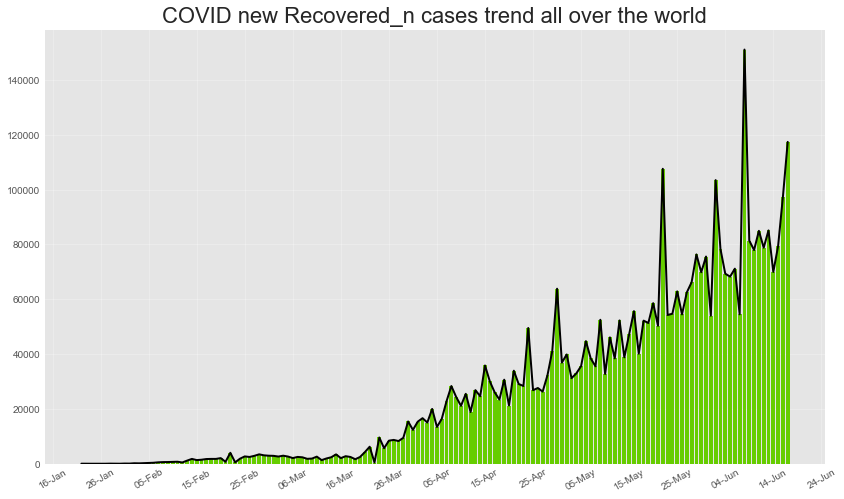

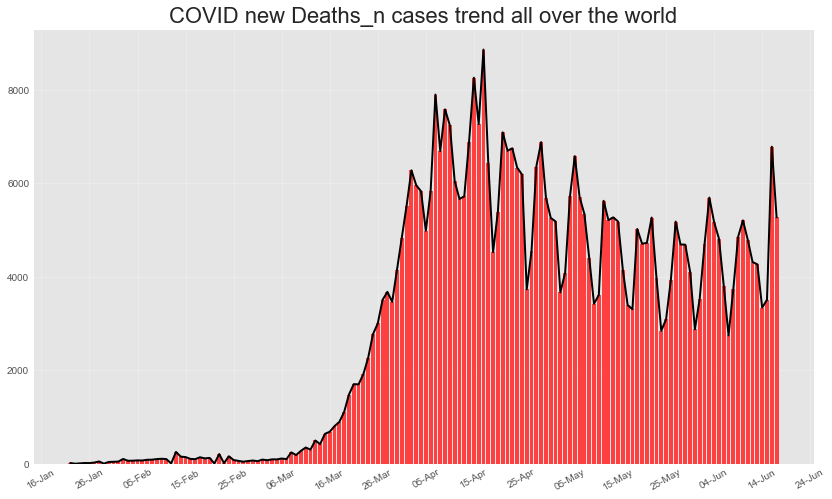

In [387]:
barplot(timed_data,'Confirmed_n','ggplot','#BF3EFF')
barplot(timed_data,'Recovered_n','ggplot','#66CD00')
barplot(timed_data,'Deaths_n','ggplot','#FF4040')

Text(0.5, 1.0, 'COVID active, recovered and death rates trend all over the world')

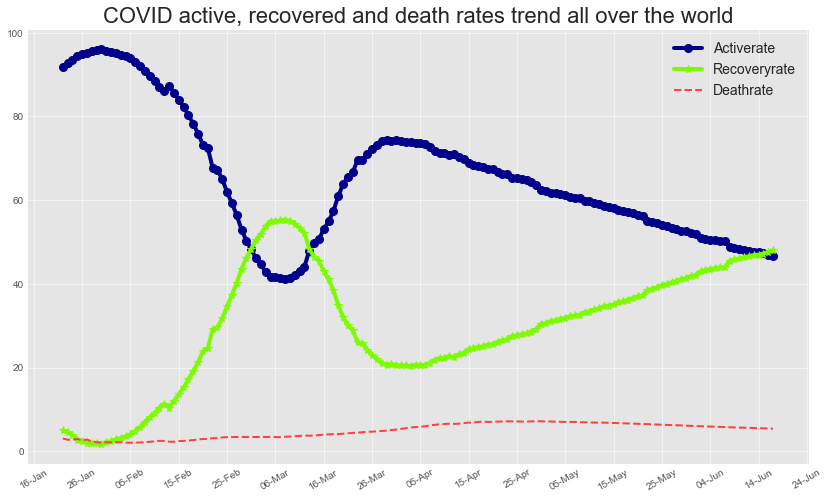

In [388]:
f,ax= plt.subplots(figsize=(14,8))

#plt.figure(figsize=(14,8))
plt.style.use('bmh')

plt.plot( 'Date','Activerate', data=timed_data, marker='o', color='#00008B',markersize=8, linewidth=4)
plt.plot( 'Date','Recoveryrate', data=timed_data, marker='*', color='#7CFC00',markersize=8, linewidth=4)
plt.plot('Date','Deathrate', data=timed_data, marker=' ', color='#FF4040', markersize=8,linewidth=2, linestyle='dashed')

plt.legend(fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=30)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.title('COVID active, recovered and death rates trend all over the world',fontsize=22)


Active cases rate has its minimum in first week of may with good recovery rate at that time, but active cases raised again till april first week beyond which downward trend is noticed. this might be because of more number of tests done in this period or infection rate raised during this period.


<Figure size 1080x2160 with 0 Axes>

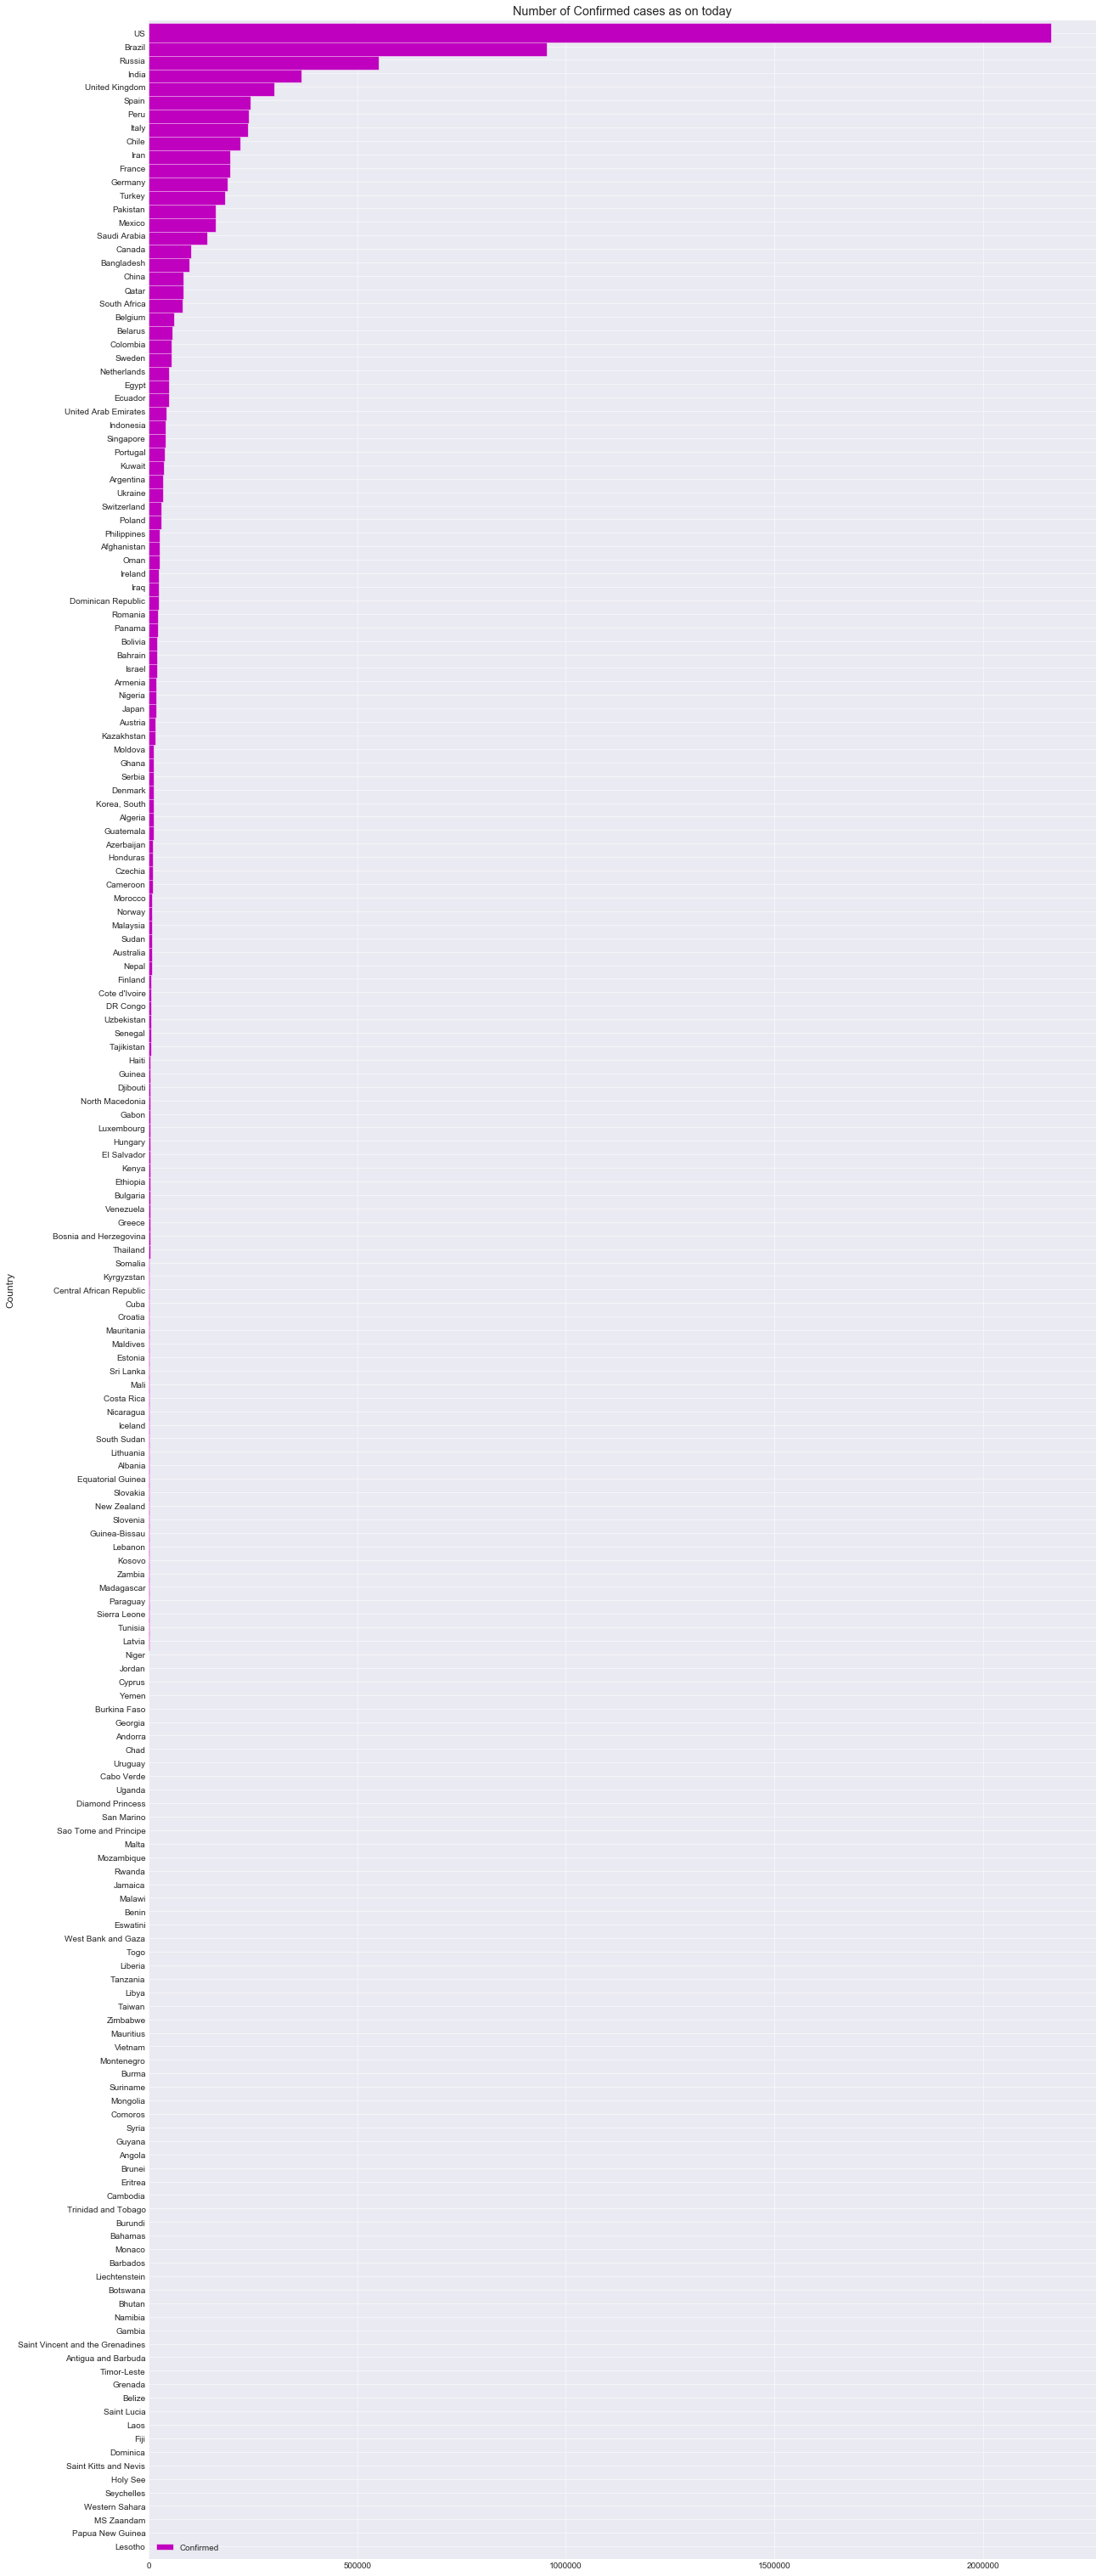

In [389]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15,30))
Data_recent=Data_recent.sort_values(by=['Confirmed'])

Data_recent.plot.barh( x="Country",y="Confirmed",width=1.4,figsize=(20,55),color='m',edgecolor='white',title="Number of Confirmed cases as on today");
plt.show()

US with highest number of Covid cases and India in 7th position as on Jun 1st 2020

Removing countries with 0 confirmed cases from our dataset as these can be considered as unaffected countries


In [390]:
least_affected=Data_recent[Data_recent['Confirmed']<10000]['Country'] ##

In [391]:
print(least_affected.values)

['Lesotho' 'Papua New Guinea' 'MS Zaandam' 'Western Sahara' 'Seychelles'
 'Holy See' 'Saint Kitts and Nevis' 'Dominica' 'Fiji' 'Laos' 'Saint Lucia'
 'Belize' 'Grenada' 'Timor-Leste' 'Antigua and Barbuda'
 'Saint Vincent and the Grenadines' 'Gambia' 'Namibia' 'Bhutan' 'Botswana'
 'Liechtenstein' 'Barbados' 'Monaco' 'Bahamas' 'Burundi'
 'Trinidad and Tobago' 'Cambodia' 'Eritrea' 'Brunei' 'Angola' 'Guyana'
 'Syria' 'Comoros' 'Mongolia' 'Suriname' 'Burma' 'Montenegro' 'Vietnam'
 'Mauritius' 'Zimbabwe' 'Taiwan' 'Libya' 'Tanzania' 'Liberia' 'Togo'
 'West Bank and Gaza' 'Eswatini' 'Benin' 'Malawi' 'Jamaica' 'Rwanda'
 'Mozambique' 'Malta' 'Sao Tome and Principe' 'San Marino'
 'Diamond Princess' 'Uganda' 'Cabo Verde' 'Uruguay' 'Chad' 'Andorra'
 'Georgia' 'Burkina Faso' 'Yemen' 'Cyprus' 'Jordan' 'Niger' 'Latvia'
 'Tunisia' 'Sierra Leone' 'Paraguay' 'Madagascar' 'Zambia' 'Kosovo'
 'Lebanon' 'Guinea-Bissau' 'Slovenia' 'New Zealand' 'Slovakia'
 'Equatorial Guinea' 'Albania' 'Lithuania' 'South Sudan

In [392]:
Data_recent.shape

(187, 12)

In [405]:

import matplotlib.colors as mcolors
def composition_cases(Data,typ):
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle('COVID '+str(typ)+' cases as on '+str(date.today()), fontsize=20)
    ax = fig.add_subplot(111, aspect="equal")
   
    Data = Data[Data[typ]>0]
    labels=[]
    for i,j in zip(Data['Country'],Data[typ]):
        k=str(i)+'\n'+str(j)
        labels.append(k)
   
    ax=squarify.plot(sizes=Data[typ], label=labels,color=mcolors.CSS4_COLORS , alpha=0.7, bar_kwargs=dict(linewidth=2, edgecolor="#222222"))
    plt.axis('off')
    #plt.rc('font', size=10)
    plt.show()
    plt.tight_layout()


In [394]:
def composition_case_top20(Data,typ):
    fig = plt.figure(figsize=(16, 16))
    fig.suptitle('COVID '+str(typ)+' top 20 countries as on '+str(date.today()), fontsize=20)
    ax = fig.add_subplot(111, aspect="equal")
   
    Data = Data[Data[typ]>0]
    Data = Data.sort_values(typ).tail(20)
    labels=[]
    for i,j in zip(Data['Country'],Data[typ]):
        k=str(i)+'\n'+str(j)
        labels.append(k)
    ax=squarify.plot(sizes=Data[typ], label=labels,color=mcolors.CSS4_COLORS , alpha=0.7, bar_kwargs=dict(linewidth=2, edgecolor="#222222"))
    plt.axis('off')
    plt.rc('font', size=10)
    plt.show()
    plt.tight_layout()


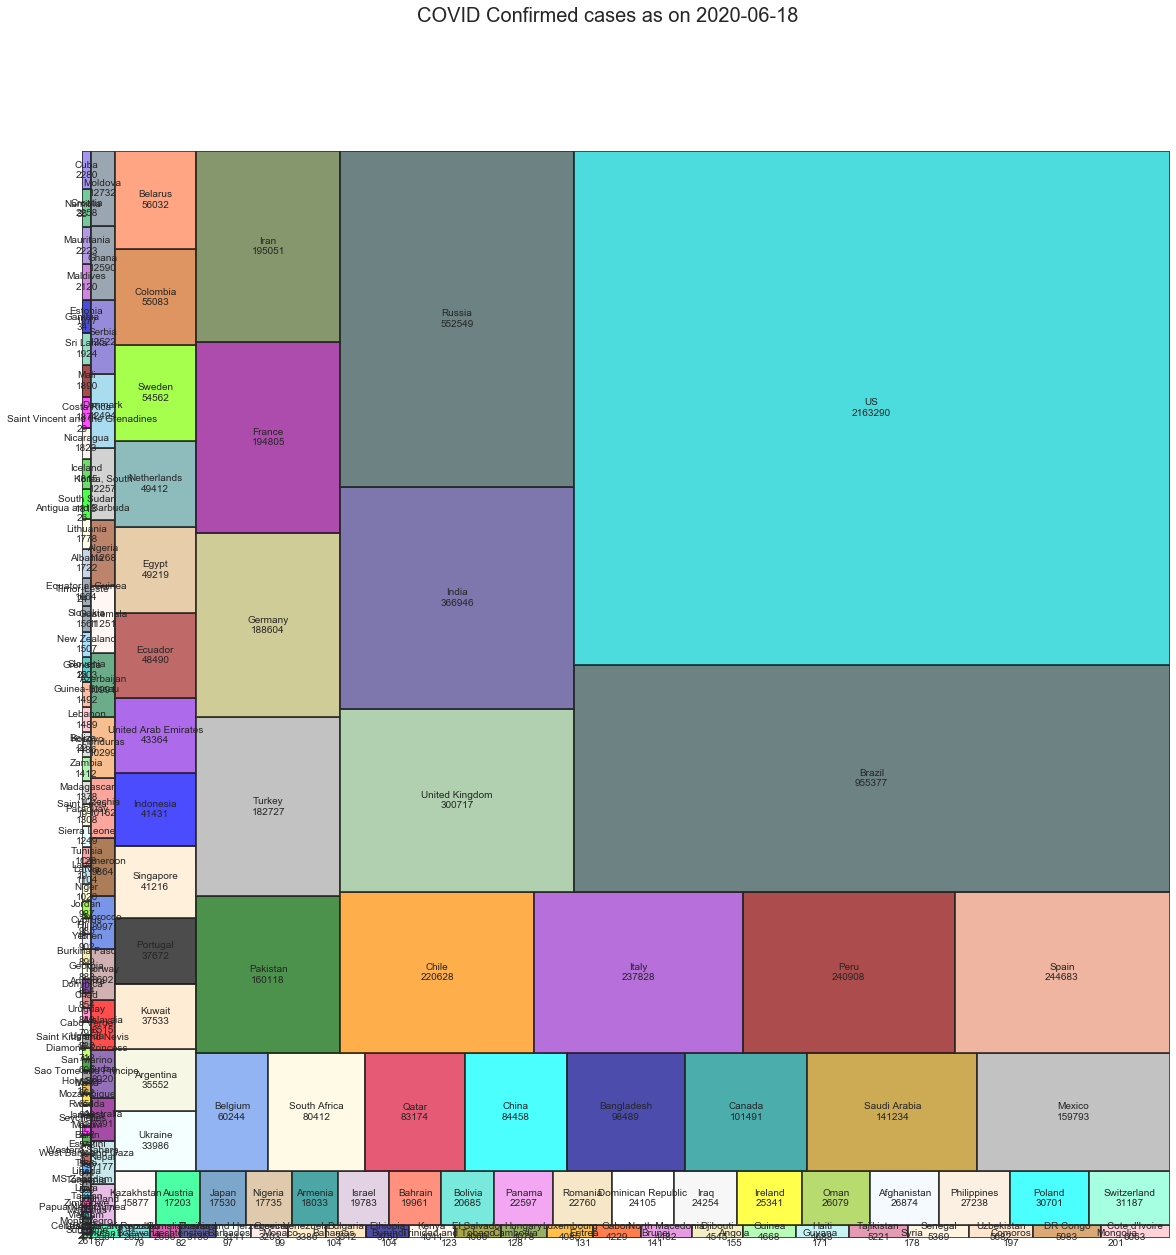

<Figure size 432x288 with 0 Axes>

In [406]:
composition_cases(Data_recent,'Confirmed')

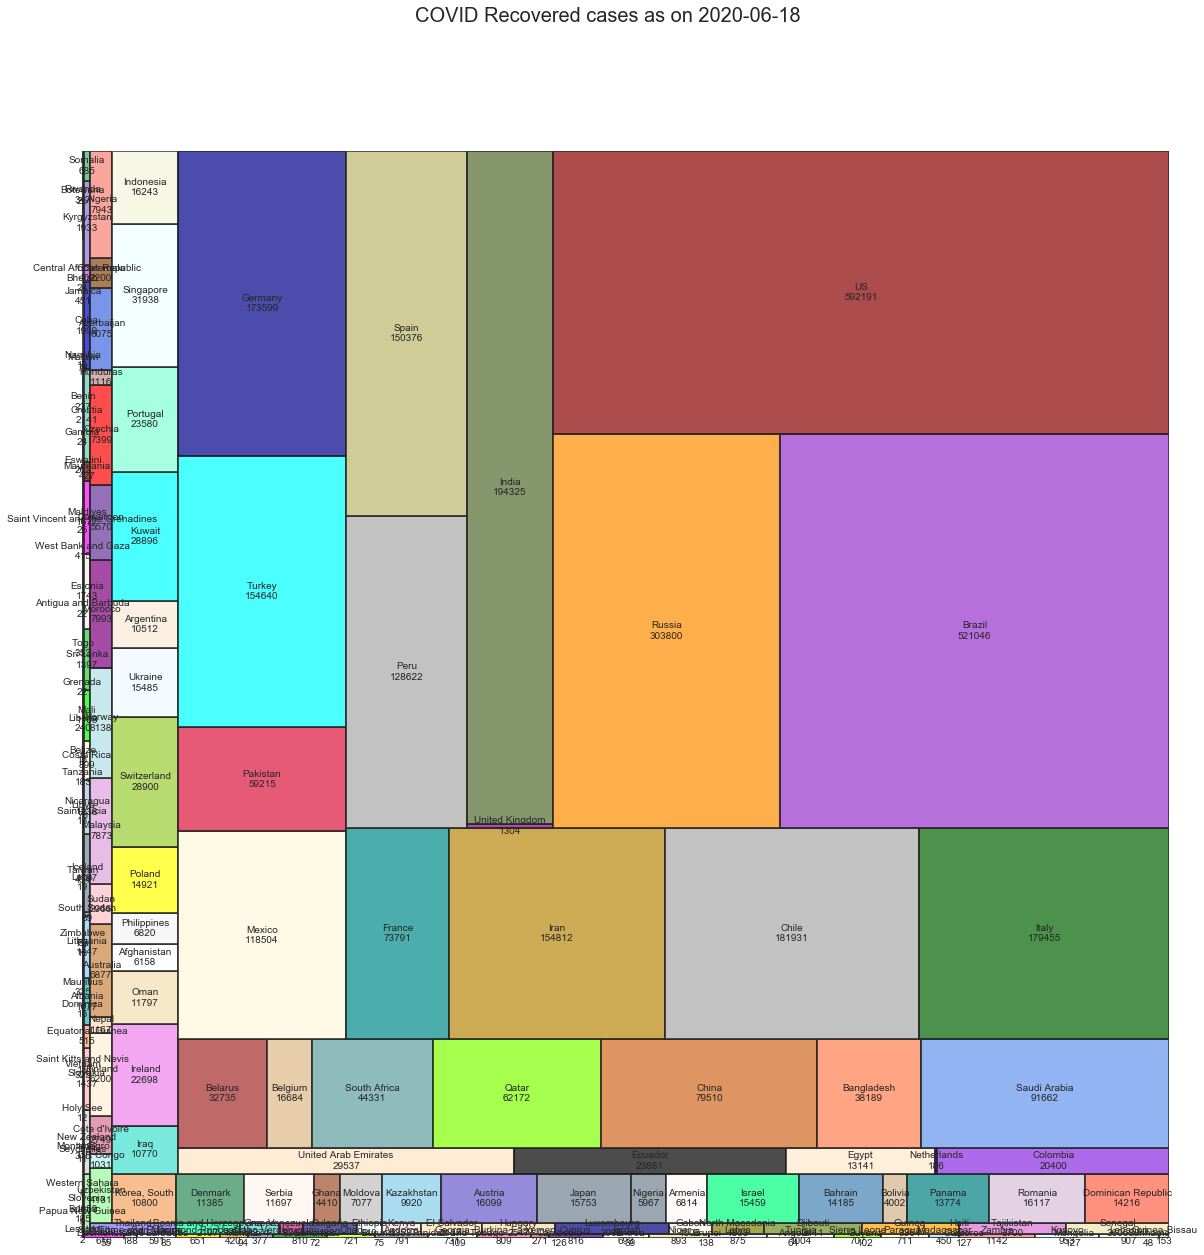

<Figure size 432x288 with 0 Axes>

In [407]:
composition_cases(Data_recent,'Recovered')

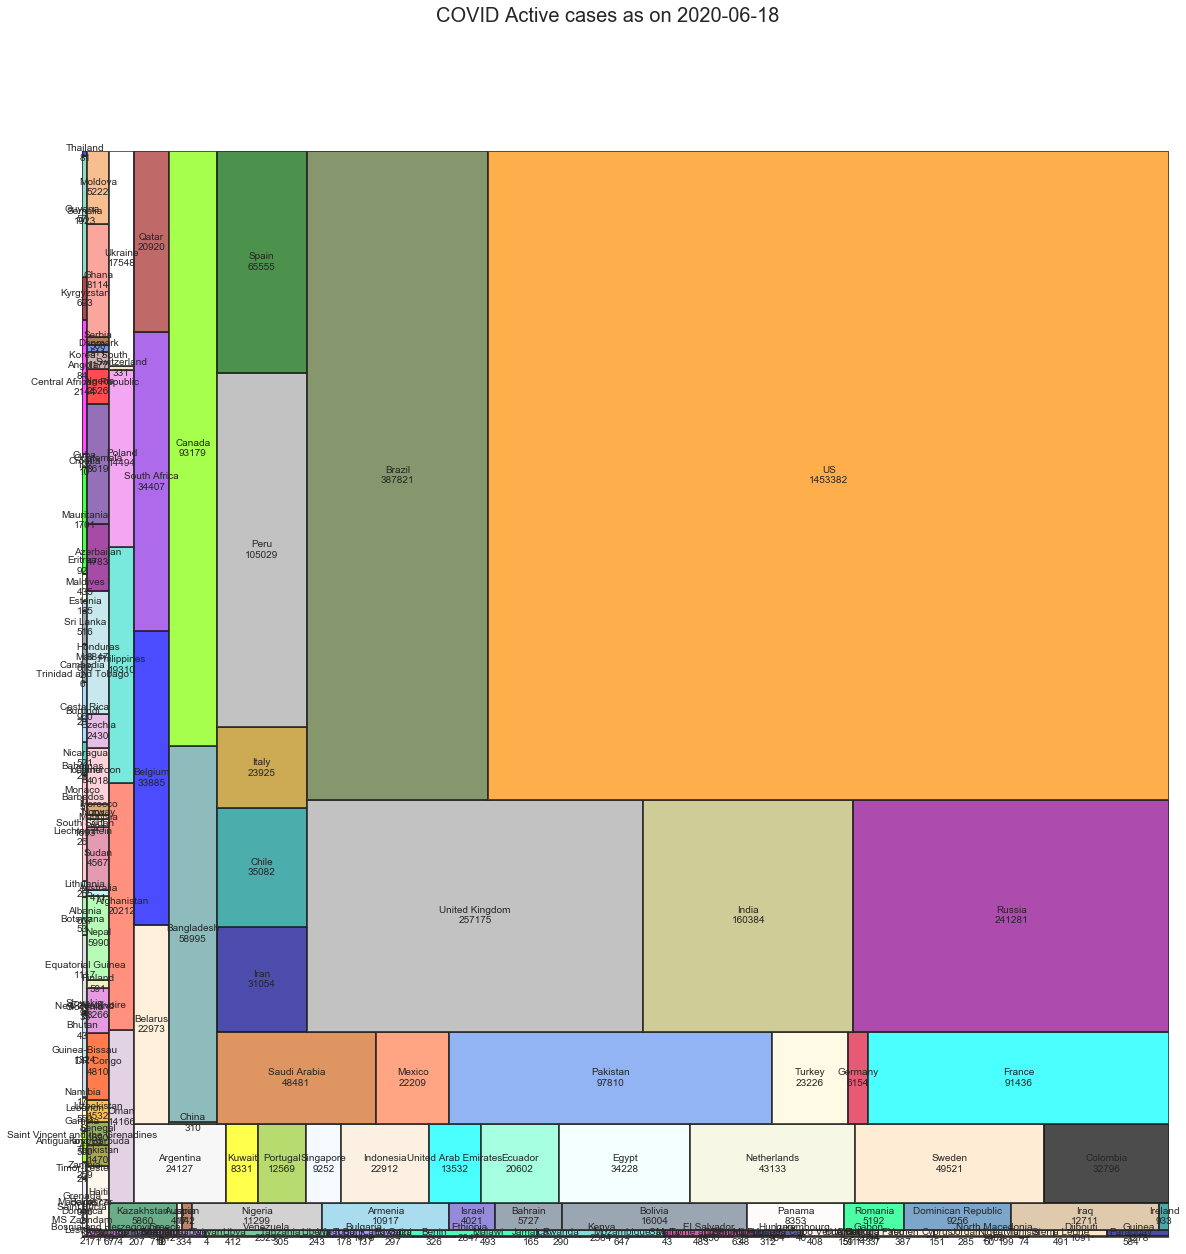

<Figure size 432x288 with 0 Axes>

In [408]:
composition_cases(Data_recent,'Active')

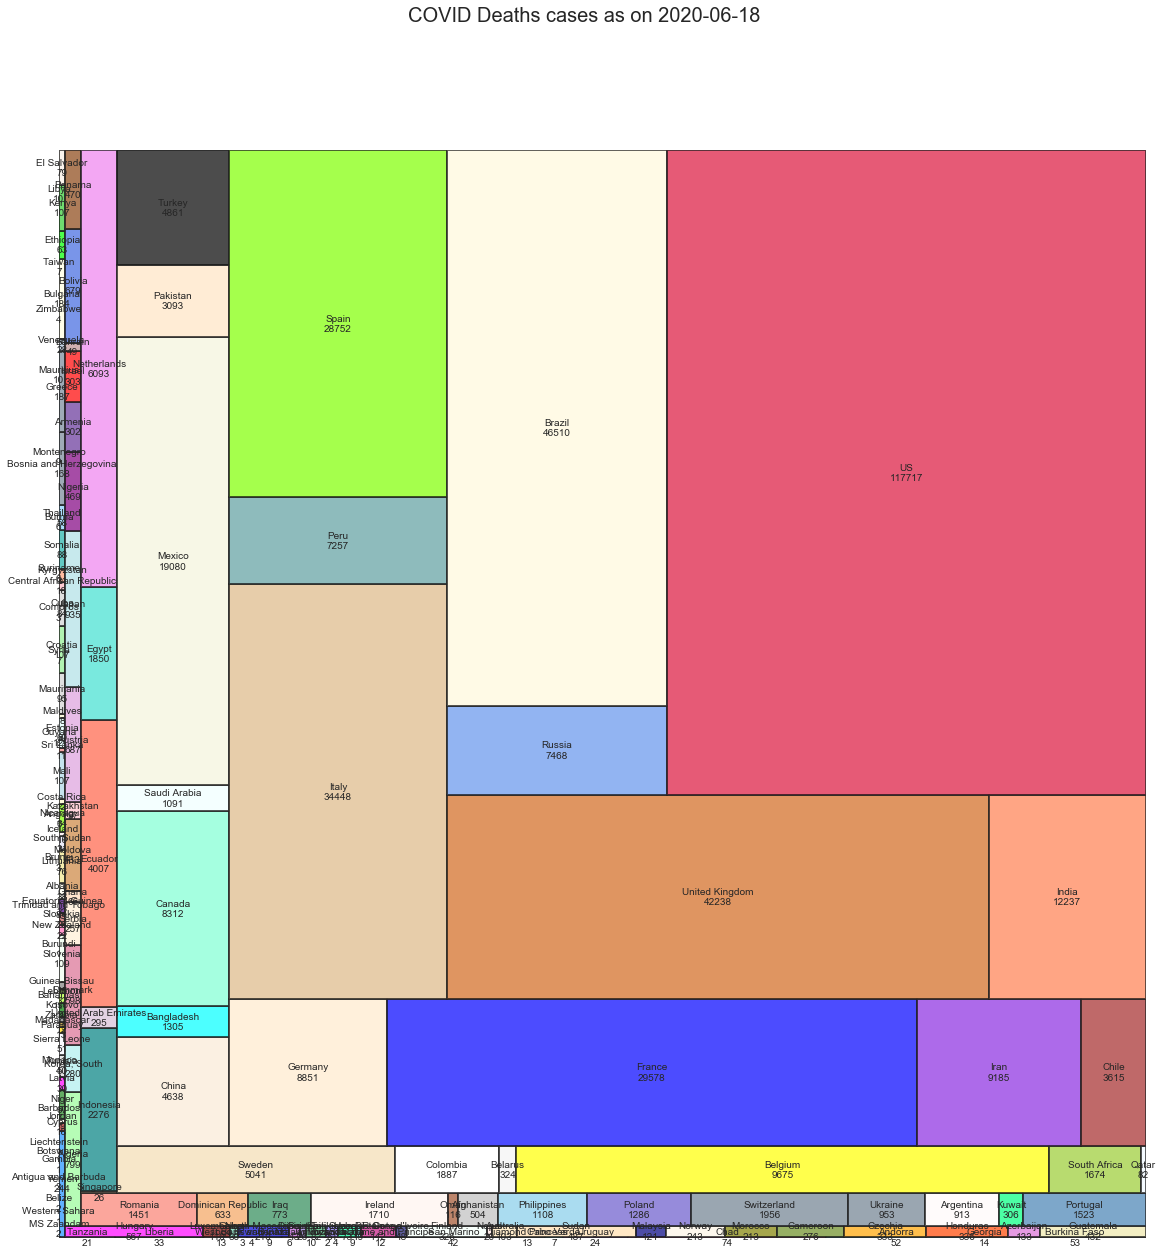

<Figure size 432x288 with 0 Axes>

In [409]:
composition_cases(Data_recent,'Deaths')

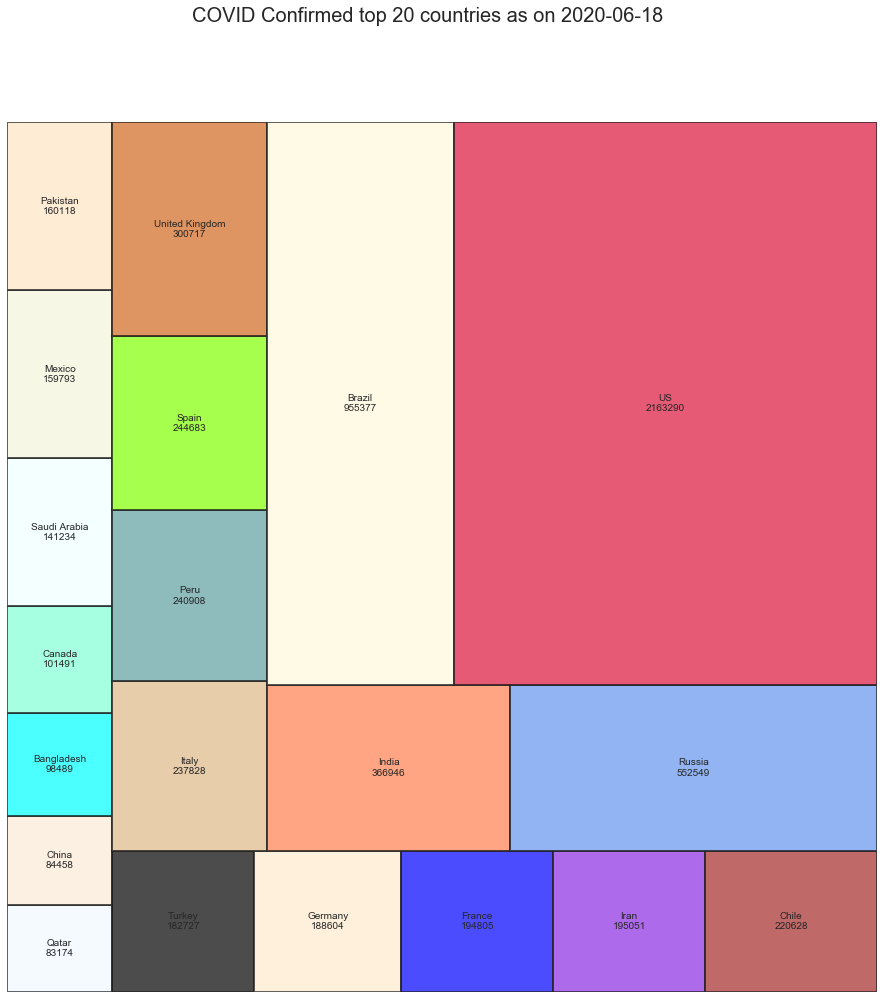

<Figure size 432x288 with 0 Axes>

In [410]:
composition_case_top20(Data_recent,'Confirmed')

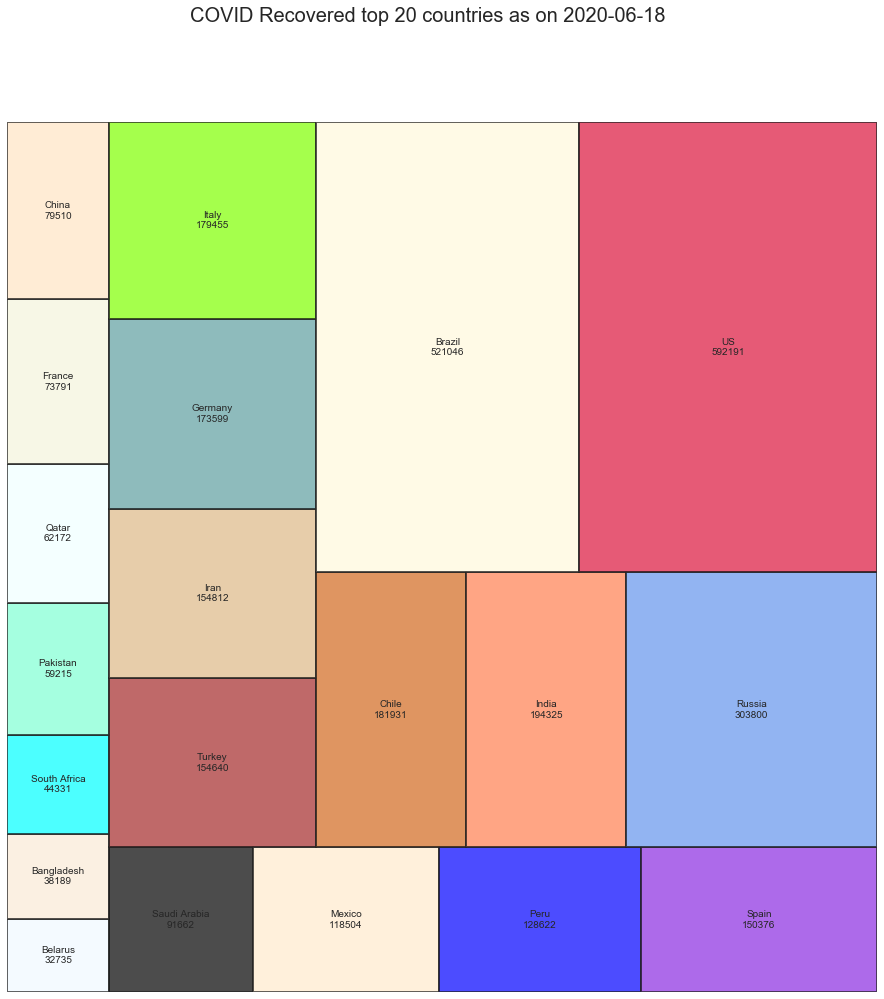

<Figure size 432x288 with 0 Axes>

In [411]:
composition_case_top20(Data_recent,'Recovered')

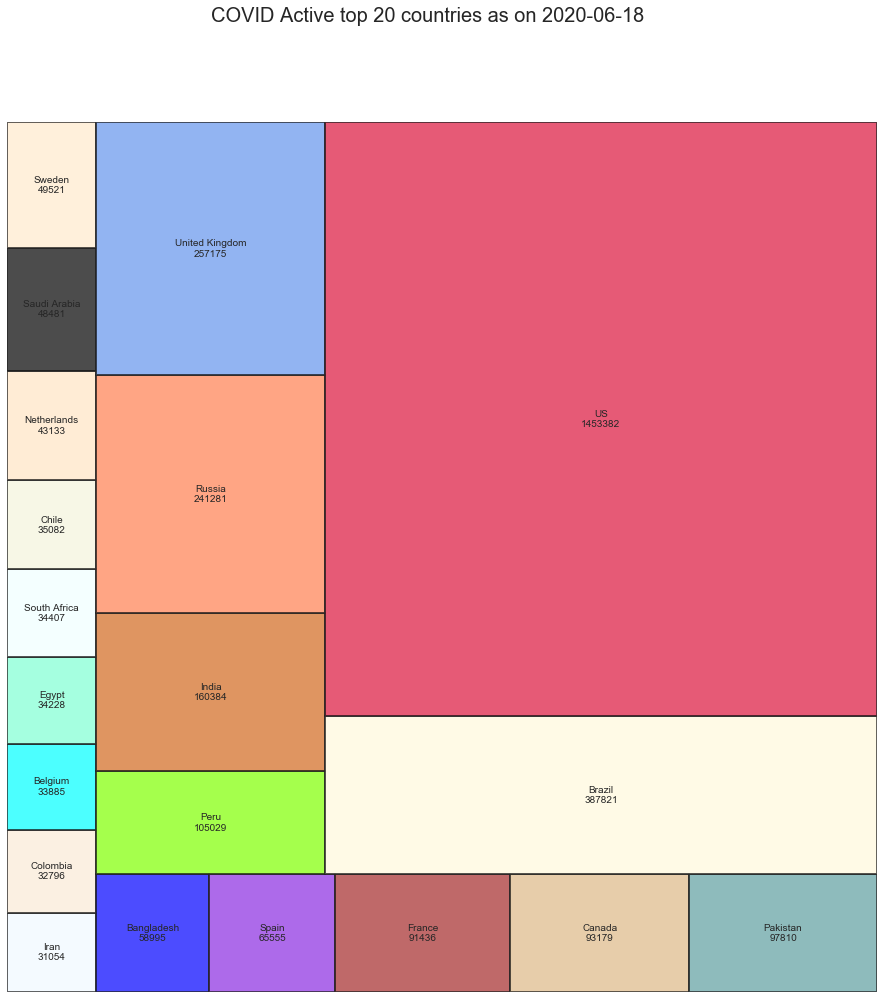

<Figure size 432x288 with 0 Axes>

In [412]:
composition_case_top20(Data_recent,'Active')

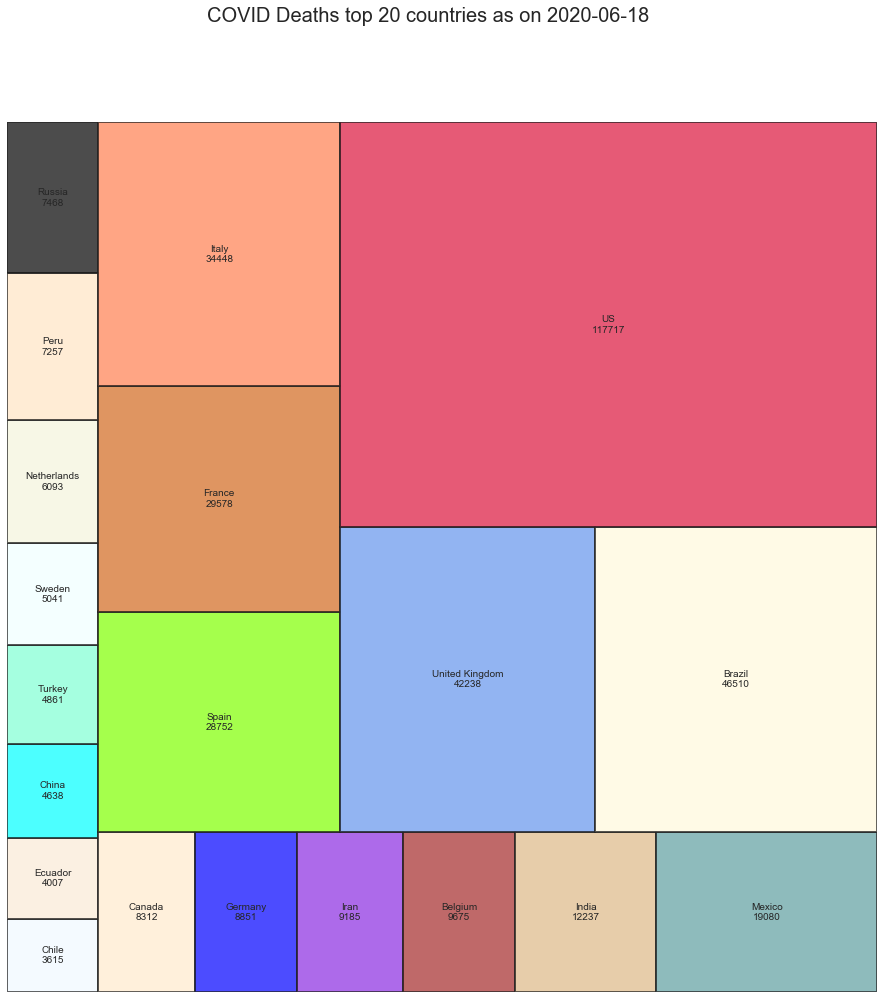

<Figure size 432x288 with 0 Axes>

In [415]:
composition_case_top20(Data_recent,'Deaths')

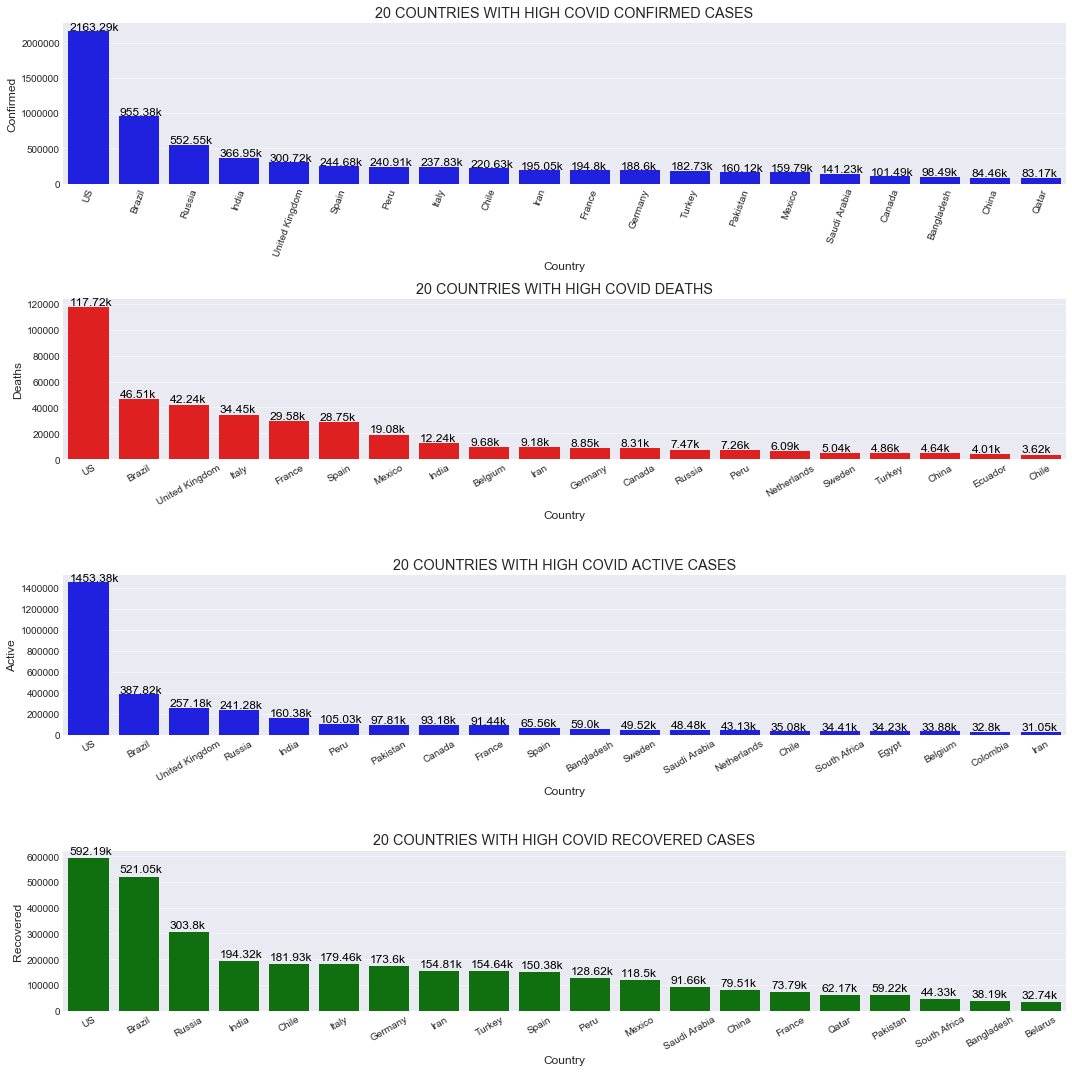

In [416]:
f, axes = plt.subplots(4, 1, figsize=(15, 15))

ax1=sns.barplot(x='Country',y='Confirmed',data= Data_recent.sort_values(by=['Confirmed'],ascending=False).head(20),color='blue',ax=axes[0])
plt.setp(axes[0].get_xticklabels(),visible=True, rotation=70)
ax1.set_title("20 COUNTRIES WITH HIGH COVID CONFIRMED CASES")
total_c=[]

for i in ax1.patches:
    ax1.text(i.get_x()+.02, i.get_height()+15000,str(round((i.get_height()/1000), 2))+'k', fontsize=12,color='black')
    
ax2=sns.barplot(x='Country',y='Deaths',data= Data_recent.sort_values(by=['Deaths'],ascending=False).head(20),color='red',ax=axes[1])
plt.setp(axes[1].get_xticklabels(), rotation=30)
ax2.set_title("20 COUNTRIES WITH HIGH COVID DEATHS")
total_c=[]

for i in ax2.patches:
    ax2.text(i.get_x()+.02, i.get_height()+1500,str(round((i.get_height()/1000), 2))+'k', fontsize=12,color='black')
    
ax3=sns.barplot(x='Country',y='Active',data= Data_recent.sort_values(by=['Active'],ascending=False).head(20),color='blue',ax=axes[2])
plt.setp(axes[2].get_xticklabels(), rotation=30)
ax3.set_title("20 COUNTRIES WITH HIGH COVID ACTIVE CASES")
total_c=[]
#for i in ax3.patches:
#    total_c.append(i.get_width())
for i in ax3.patches:
    ax3.text(i.get_x()+.02, i.get_height()+15000,str(round((i.get_height()/1000), 2))+'k', fontsize=12,color='black')
    
ax4=sns.barplot(x='Country',y='Recovered',data= Data_recent.sort_values(by=['Recovered'],ascending=False).head(20),color='green',ax=axes[3])
plt.setp(axes[3].get_xticklabels(), rotation=30)

for i in ax4.patches:
    ax4.text(i.get_x()+.02, i.get_height()+15000,str(round((i.get_height()/1000), 2))+'k', fontsize=12,color='black')
ax4.set_title("20 COUNTRIES WITH HIGH COVID RECOVERED CASES")
plt.tight_layout()

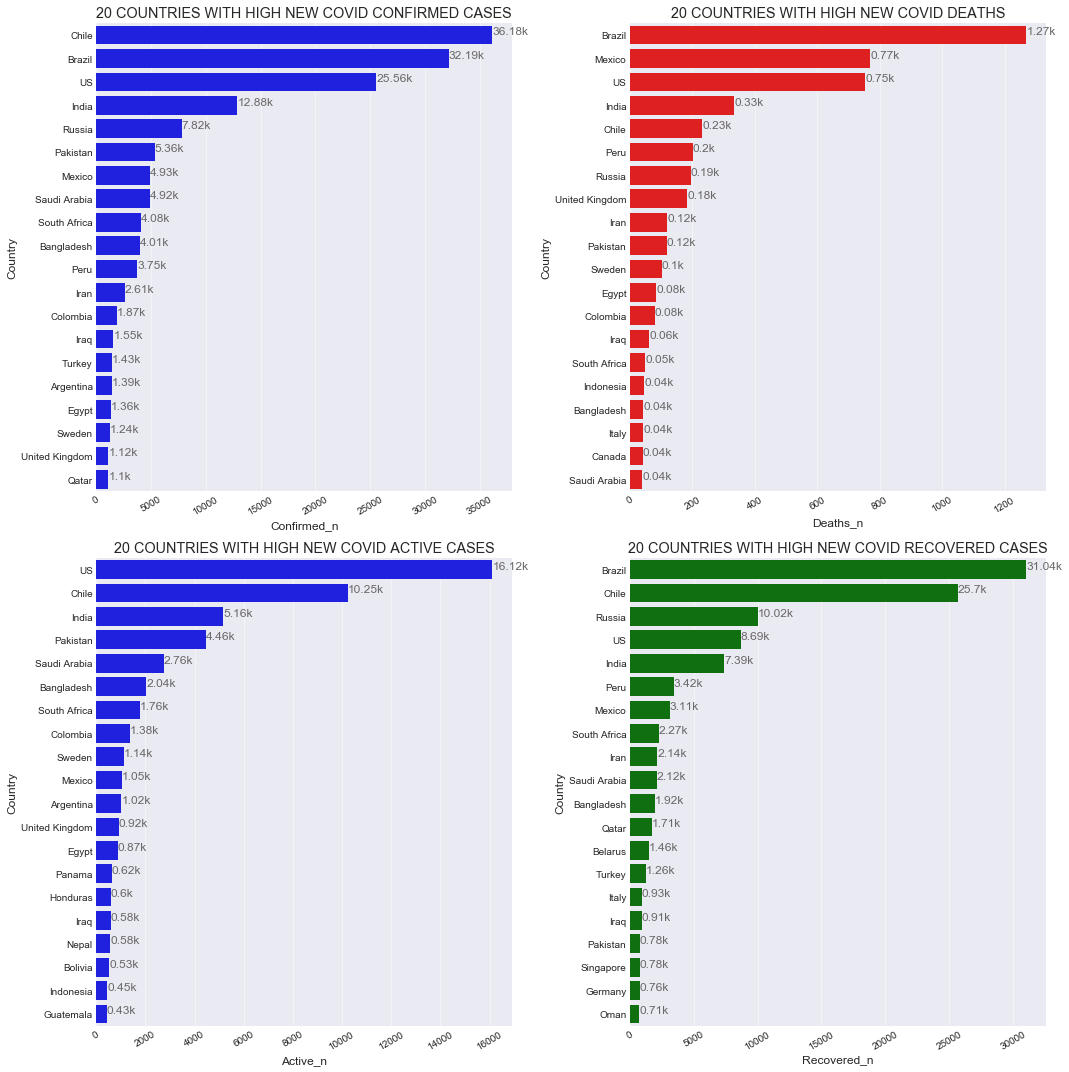

In [417]:
f, axes = plt.subplots(2, 2, figsize=(15, 15))

ax1=sns.barplot(x='Confirmed_n',y='Country',data= Data_recent.sort_values(by=['Confirmed_n'],ascending=False).head(20),color='blue',ax=axes[0, 0])
plt.setp(axes[0,0].get_xticklabels(),visible=True, rotation=30)
ax1.set_title("20 COUNTRIES WITH HIGH NEW COVID CONFIRMED CASES")
total_c=[]

for i in ax1.patches:
    ax1.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')

ax2=sns.barplot(x='Deaths_n',y='Country',data= Data_recent.sort_values(by=['Deaths_n'],ascending=False).head(20),color='red',ax=axes[0, 1])
plt.setp(axes[0,1].get_xticklabels(), rotation=30)
ax2.set_title("20 COUNTRIES WITH HIGH NEW COVID DEATHS")
total_c=[]

for i in ax2.patches:
    ax2.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax3=sns.barplot(x='Active_n',y='Country',data= Data_recent.sort_values(by=['Active_n'],ascending=False).head(20),color='blue',ax=axes[1, 0])
plt.setp(axes[1,0].get_xticklabels(), rotation=30)
ax3.set_title("20 COUNTRIES WITH HIGH NEW COVID ACTIVE CASES")
total_c=[]
#for i in ax3.patches:
#    total_c.append(i.get_width())
for i in ax3.patches:
    ax3.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax4=sns.barplot(x='Recovered_n',y='Country',data= Data_recent.sort_values(by=['Recovered_n'],ascending=False).head(20),color='green',ax=axes[1, 1])
plt.setp(axes[1,1].get_xticklabels(), rotation=30)

for i in ax4.patches:
    ax4.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax4.set_title("20 COUNTRIES WITH HIGH NEW COVID RECOVERED CASES")
plt.tight_layout()

In [418]:
Most_affected=Data_recent[Data_recent['Confirmed']>100000]

In [419]:

print(Most_affected.shape)
Most_affected.style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='Blues',subset=["Confirmed_n"])\
                        .background_gradient(cmap='Reds',subset=["Deaths_n"])\
                        .background_gradient(cmap='Greens',subset=["Recovered_n"])\
                        .background_gradient(cmap='YlOrBr',subset=["Active_n"])\
                        .background_gradient(cmap='spring',subset=["Deathrate"])\
                        .background_gradient(cmap='summer',subset=["Recoveryrate"])

(17, 12)


13 countries with more than one lakh affected cases are found. furthur analysis on these countries would be done

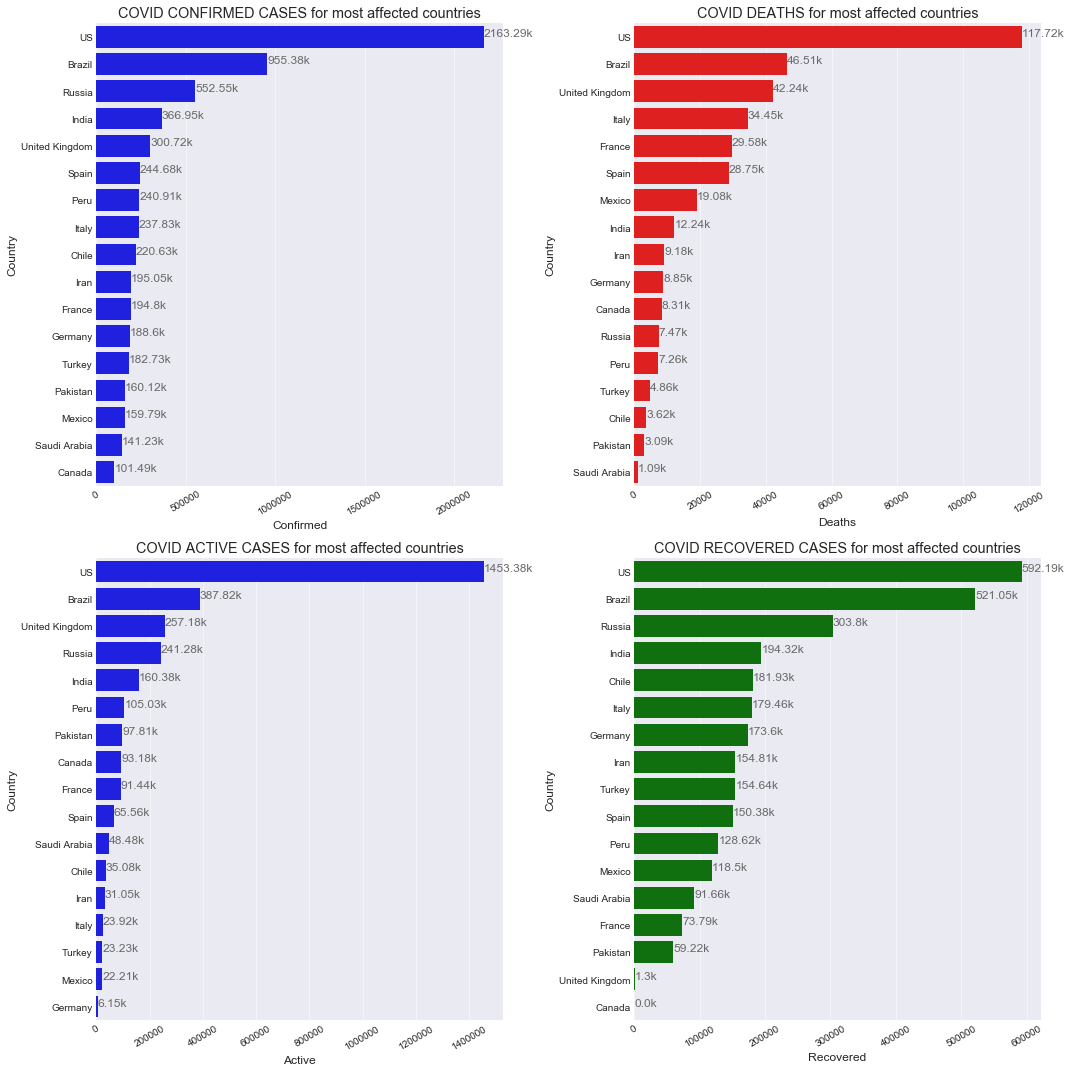

In [420]:
f, axes = plt.subplots(2, 2, figsize=(15, 15))

ax1=sns.barplot(x='Confirmed',y='Country',data= Most_affected.sort_values(by=['Confirmed'],ascending=False),color='blue',ax=axes[0, 0])
plt.setp(axes[0,0].get_xticklabels(),visible=True, rotation=30)
ax1.set_title("COVID CONFIRMED CASES for most affected countries")
total_c=[]

for i in ax1.patches:
    ax1.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')

ax2=sns.barplot(x='Deaths',y='Country',data= Most_affected.sort_values(by=['Deaths'],ascending=False),color='red',ax=axes[0, 1])
plt.setp(axes[0,1].get_xticklabels(), rotation=30)
ax2.set_title("COVID DEATHS for most affected countries")
total_c=[]

for i in ax2.patches:
    ax2.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax3=sns.barplot(x='Active',y='Country',data= Most_affected.sort_values(by=['Active'],ascending=False),color='blue',ax=axes[1, 0])
plt.setp(axes[1,0].get_xticklabels(), rotation=30)
ax3.set_title("COVID ACTIVE CASES for most affected countries")
total_c=[]
#for i in ax3.patches:
#    total_c.append(i.get_width())
for i in ax3.patches:
    ax3.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax4=sns.barplot(x='Recovered',y='Country',data= Most_affected.sort_values(by=['Recovered'],ascending=False),color='green',ax=axes[1, 1])
plt.setp(axes[1,1].get_xticklabels(), rotation=30)

for i in ax4.patches:
    ax4.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax4.set_title("COVID RECOVERED CASES for most affected countries")
plt.tight_layout()

In [421]:
Most_affected[Most_affected['Country']=='US']

Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  Deaths_n  \
25751      US 2020-06-17    2163290  117717     592191        25559       754   

       Recovered_n  Deathrate  Recoveryrate   Active  Active_n  
25751         8688       5.44         27.37  1453382     16117

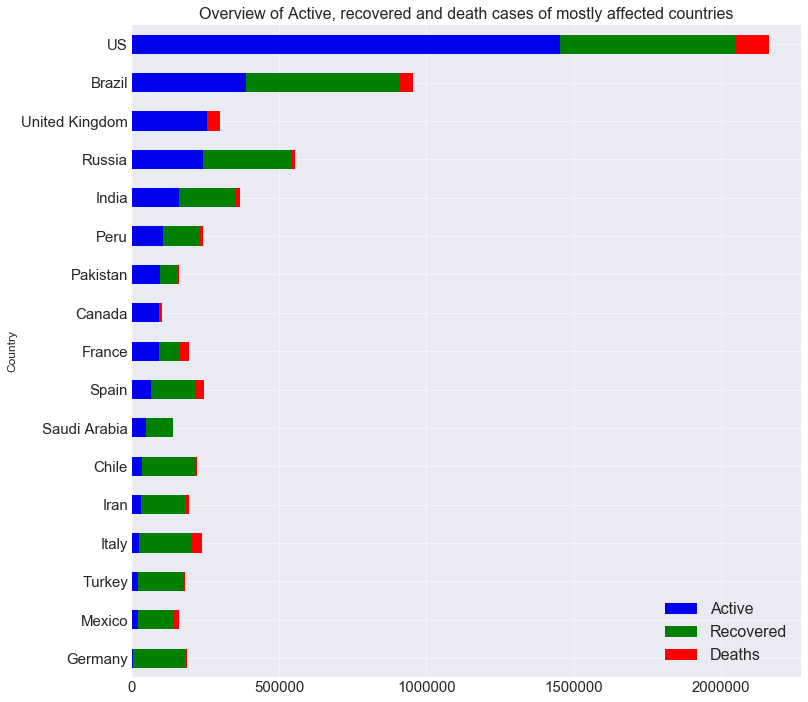

In [422]:

color=['#0000EE','green','red'] 
Most_affected = Most_affected.sort_values(by=['Confirmed'])
x=Most_affected[['Country','Active','Recovered','Deaths']]
y=x.set_index('Country')
z=y.groupby('Country').sum().sort_values(by=['Active'])
f=z.plot.barh(color=color,stacked=True,figsize=(12,12),fontsize=15,title='Overview of Active, recovered and death cases of mostly affected countries')
plt.legend(loc=4, prop={'size': 16})
f.title.set_fontsize(16)

Recovery rate is quite low in some countries.From the plot its evident that Germany has better recovery rate than other most affected countries.lets have a look at death rate and recovery rate in each country.

In [423]:
# Plotting Top 15 countries with best recovery rate and highest death rate 

In [424]:
#f, axes = plt.subplots(1,2,figsize=(15, 15), sharex=True)
r= Data_recent[['Country','Recoveryrate','Confirmed']].sort_values(by=['Recoveryrate']).tail(15)
r

Country  Recoveryrate  Confirmed
10211                Grenada         95.65         23
15243             Luxembourg         96.33       4085
16575              Mauritius         96.44        337
26935                Vietnam         97.01        335
24419                 Taiwan         97.53        445
3699                  Brunei         97.87        141
18203            New Zealand         98.34       1507
4587                Cambodia         98.44        128
11543                Iceland         99.01       1815
19535       Papua New Guinea        100.00          8
11099               Holy See        100.00         12
22199             Seychelles        100.00         11
21015  Saint Kitts and Nevis        100.00         15
14059                   Laos        100.00         19
8879                    Fiji        100.00         18

In [425]:
#Lowest death rate
d=Data_recent[['Country','Deathrate']].sort_values(by=['Deathrate']).head(15)
d

Country  Deathrate
14503                           Lesotho        0.0
17167                          Mongolia        0.0
25899                            Uganda        0.0
8287                            Eritrea        0.0
4587                           Cambodia        0.0
17759                           Namibia        0.0
21311  Saint Vincent and the Grenadines        0.0
25011                       Timor-Leste        0.0
10211                           Grenada        0.0
21163                       Saint Lucia        0.0
2959                             Bhutan        0.0
26935                           Vietnam        0.0
8879                               Fiji        0.0
7399                           Dominica        0.0
21015             Saint Kitts and Nevis        0.0

In [426]:
#Most_affected['Deathrate']= round(Most_affected['Deaths']/Most_affected['Confirmed']*100,2)
#Most_affected['Recoveryrate']= round(Most_affected['Recovered']/Most_affected['Confirmed']*100,2)
Most_affected.sort_values(by=['Confirmed'],ascending=False,inplace=True)
Most_affected.head()



Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  \
25751              US 2020-06-17    2163290  117717     592191        25559   
3551           Brazil 2020-06-17     955377   46510     521046        32188   
20719          Russia 2020-06-17     552549    7468     303800         7824   
11691           India 2020-06-17     366946   12237     194325        12881   
26343  United Kingdom 2020-06-17     300717   42238       1304         1117   

       Deaths_n  Recovered_n  Deathrate  Recoveryrate   Active  Active_n  
25751       754         8688       5.44         27.37  1453382     16117  
3551       1269        31041       4.87         54.54   387821      -122  
20719       194        10020       1.35         54.98   241281     -2390  
11691       334         7390       3.33         52.96   160384      5157  
26343       184           11      14.05          0.43   257175       922

Text(0.5, 1.0, 'Recovery rate of most affected countries ')

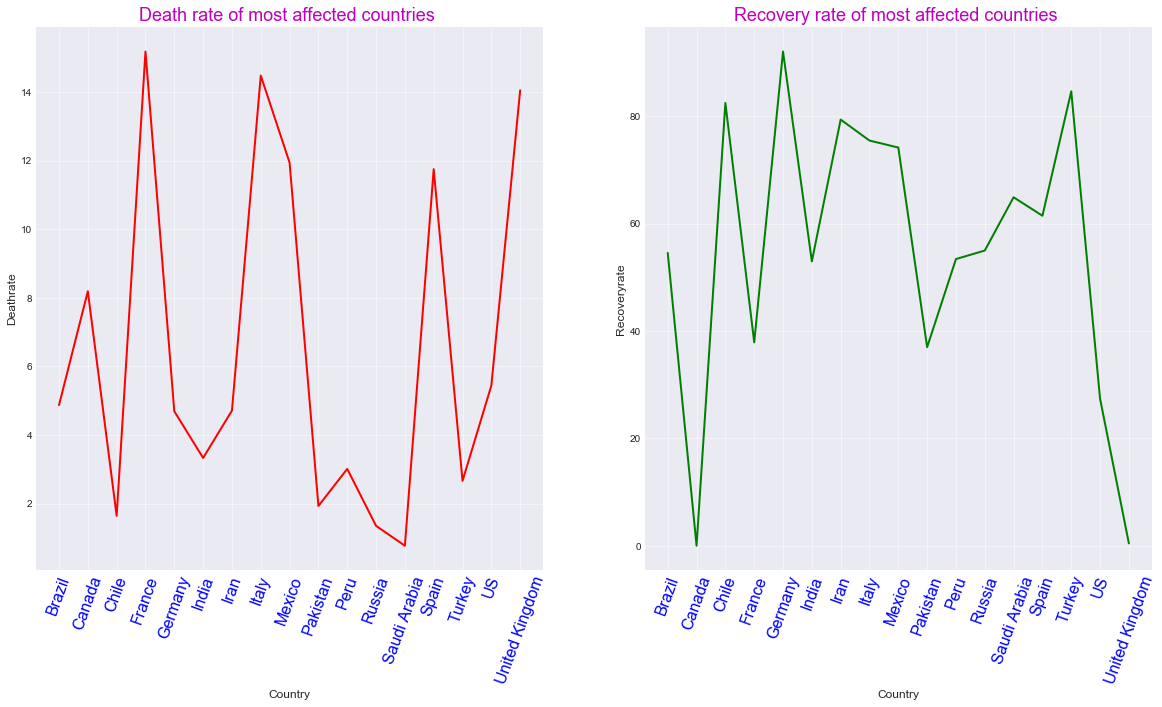

In [427]:
plt.figure(figsize=(20,10))
plt.style.use('seaborn-darkgrid')
plt.subplot(1, 2, 1)
ax1=sns.lineplot(x='Country',y='Deathrate',data=Most_affected,color='red')
ax1.set_title('Death rate of most affected countries ',fontsize=18,color='m')
plt.xticks(fontsize=16,color='blue')
plt.xticks(rotation=70)

plt.subplot(1, 2, 2)
ax2=sns.lineplot(x='Country',y='Recoveryrate',data=Most_affected,color='green')
plt.xticks(rotation=70)
plt.xticks(fontsize=16,color='blue')

ax2.set_title('Recovery rate of most affected countries ',fontsize=18,color='m')

Lets have a look at temporial analysis of covid cases 


188 countries with data from 22 jun 2020 till today

How about temporial analysis of covid cases,what is the trend for most affected countries

In [428]:
first=timed_data['Date'].min().strftime('%b%d-%Y')

now=date.today().strftime('%b%d-%Y')


In [429]:
Affected=[]
Affected=Most_affected['Country']
Affected.values


array(['US', 'Brazil', 'Russia', 'India', 'United Kingdom', 'Spain',
       'Peru', 'Italy', 'Chile', 'Iran', 'France', 'Germany', 'Turkey',
       'Pakistan', 'Mexico', 'Saudi Arabia', 'Canada'], dtype=object)

In [430]:
df_affected=World_Data[World_Data['Country'].isin(Affected)]
df_affected.shape

(2516, 12)

<Figure size 1440x1080 with 0 Axes>

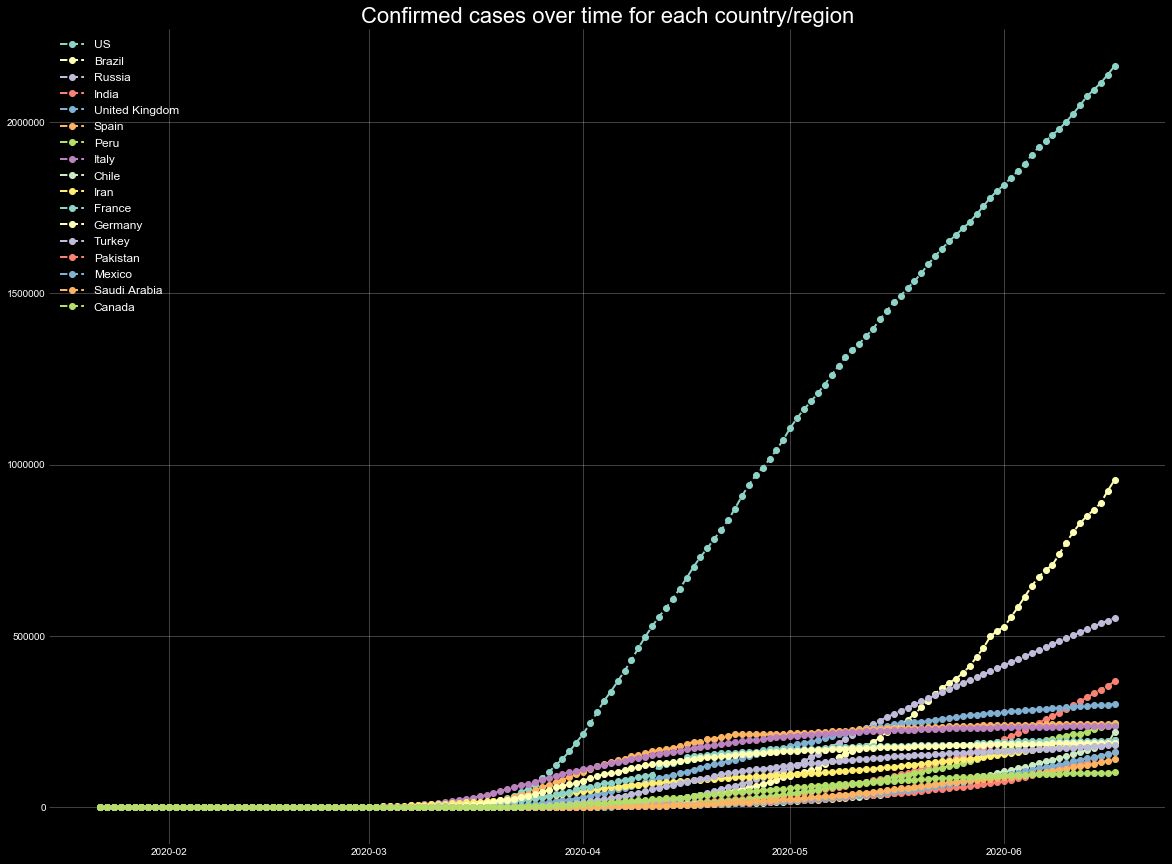

In [431]:
def plot_overtime(df_affected,col,plot_style):
    plt.style.use(plot_style)
    plt.figure(figsize=(20,15))
    fig,ax=plt.subplots(figsize=(20,15))
    for j,i in zip(Affected,range(len(Affected))):
        plt.plot_date(y=df_affected[df_affected['Country']==j][col],x= df_affected[df_affected['Country']==j]['Date'],label = j,ls ='dashed')
    
    plt.legend(fontsize=12);
    plt.title(str(col)+' cases over time for each country/region',fontsize=22)
    plt.grid(linewidth=0.5,alpha=0.5)
plot_overtime(df_affected,'Confirmed','dark_background')

<Figure size 1440x1080 with 0 Axes>

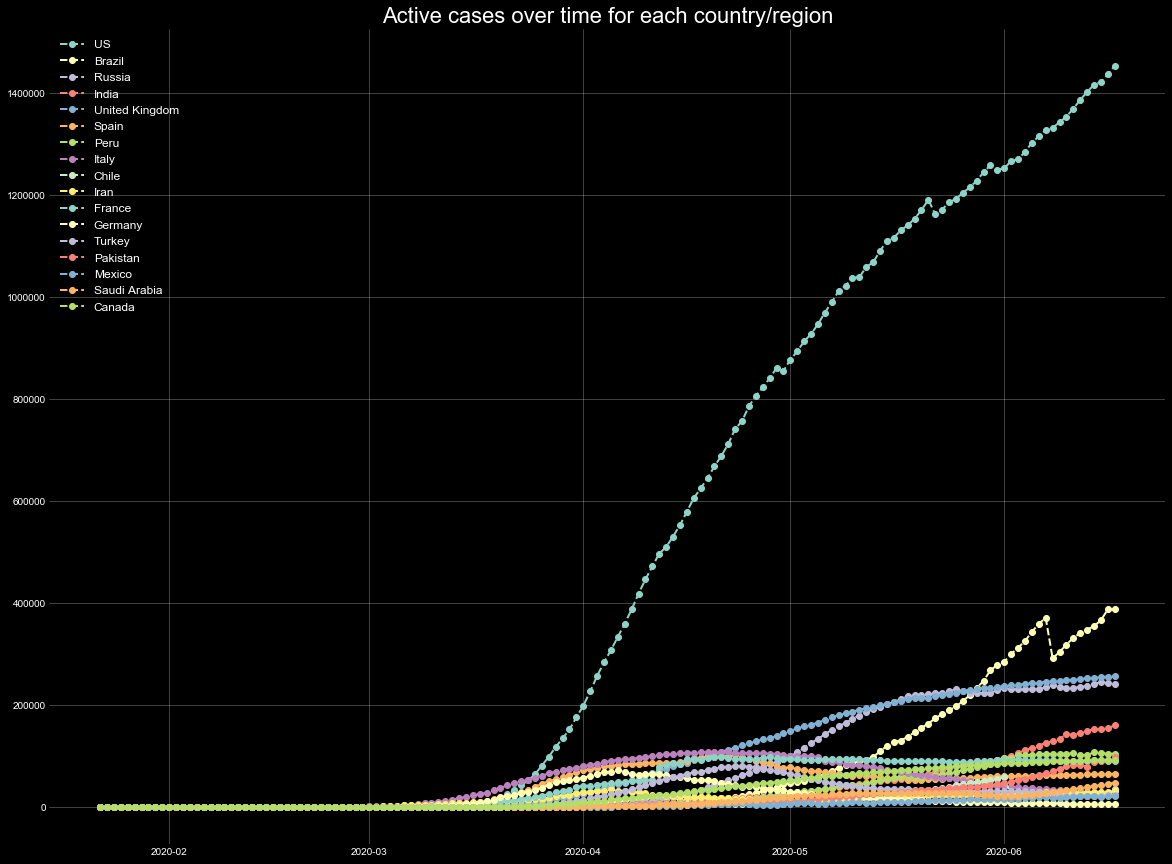

In [432]:
plot_overtime(df_affected,'Active','dark_background')

<Figure size 1440x1080 with 0 Axes>

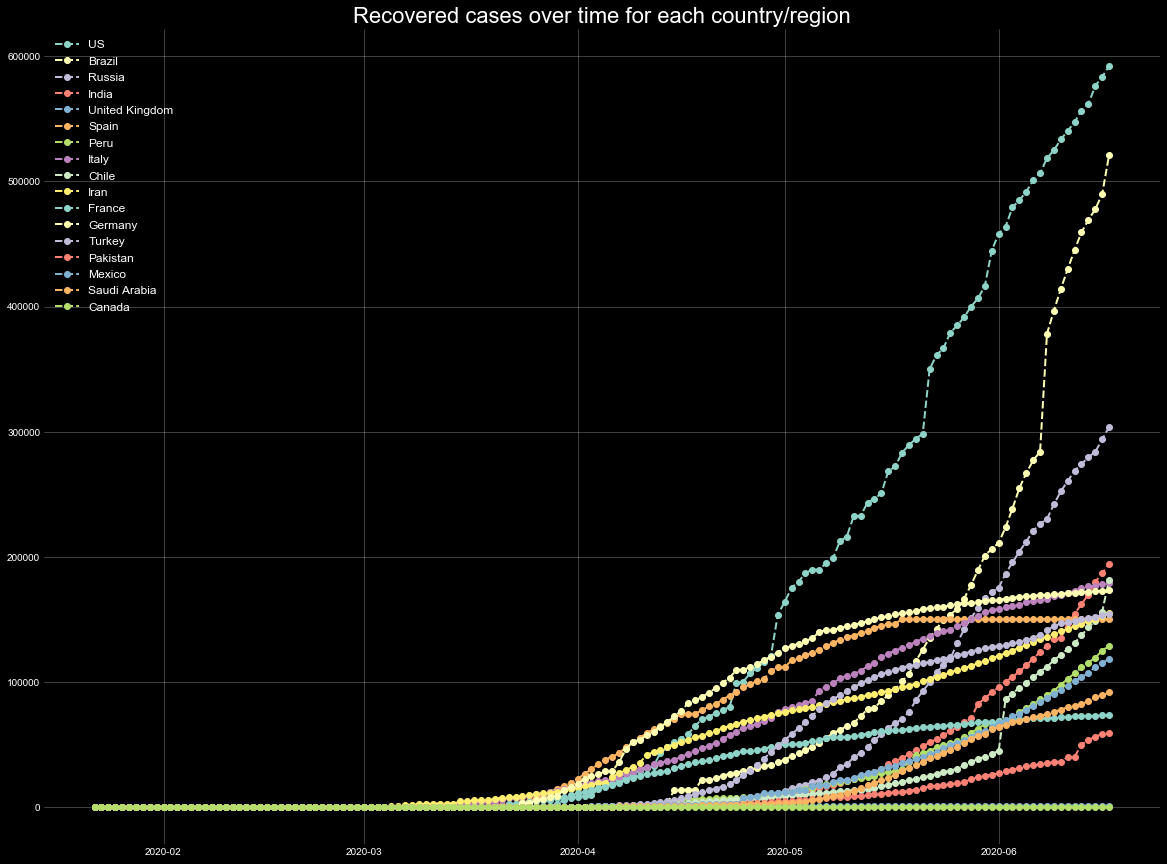

In [433]:
plot_overtime(df_affected,'Recovered','dark_background')

<Figure size 1440x1080 with 0 Axes>

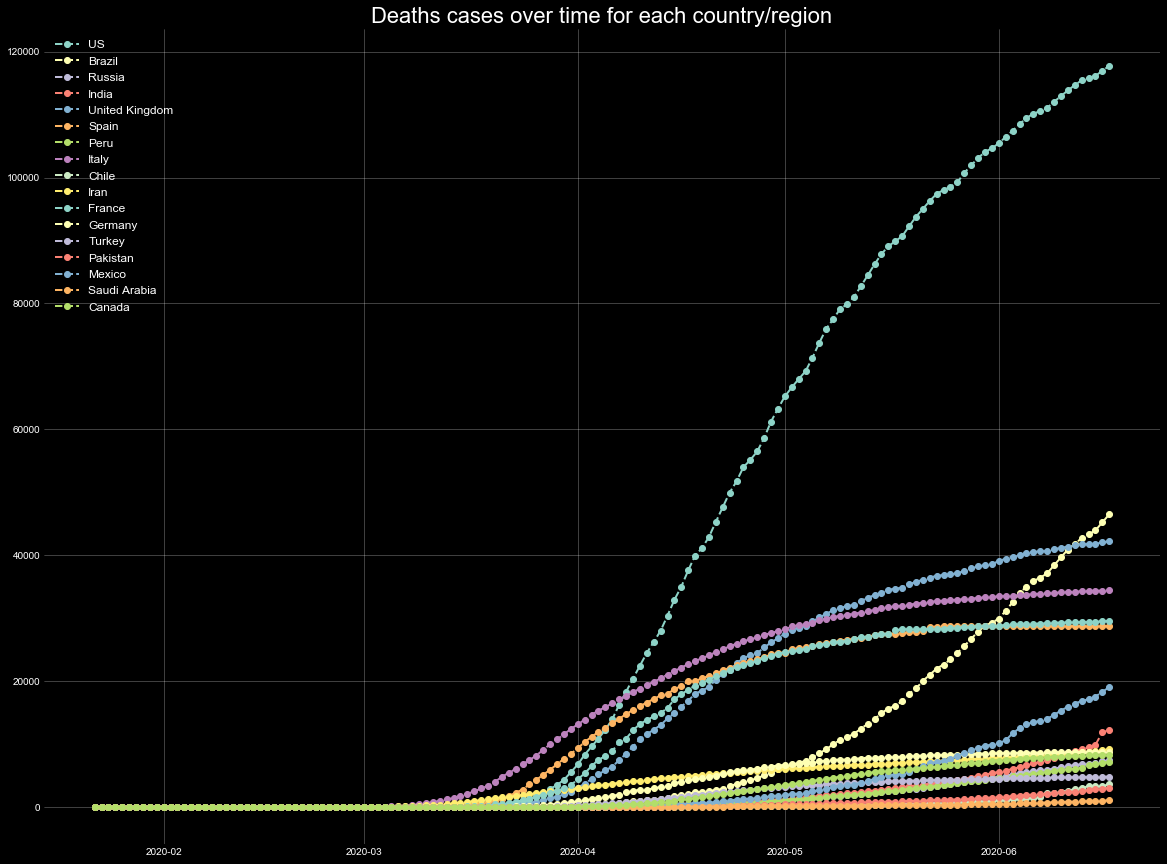

In [434]:
plot_overtime(df_affected,'Deaths','dark_background')


<Figure size 1440x1080 with 0 Axes>

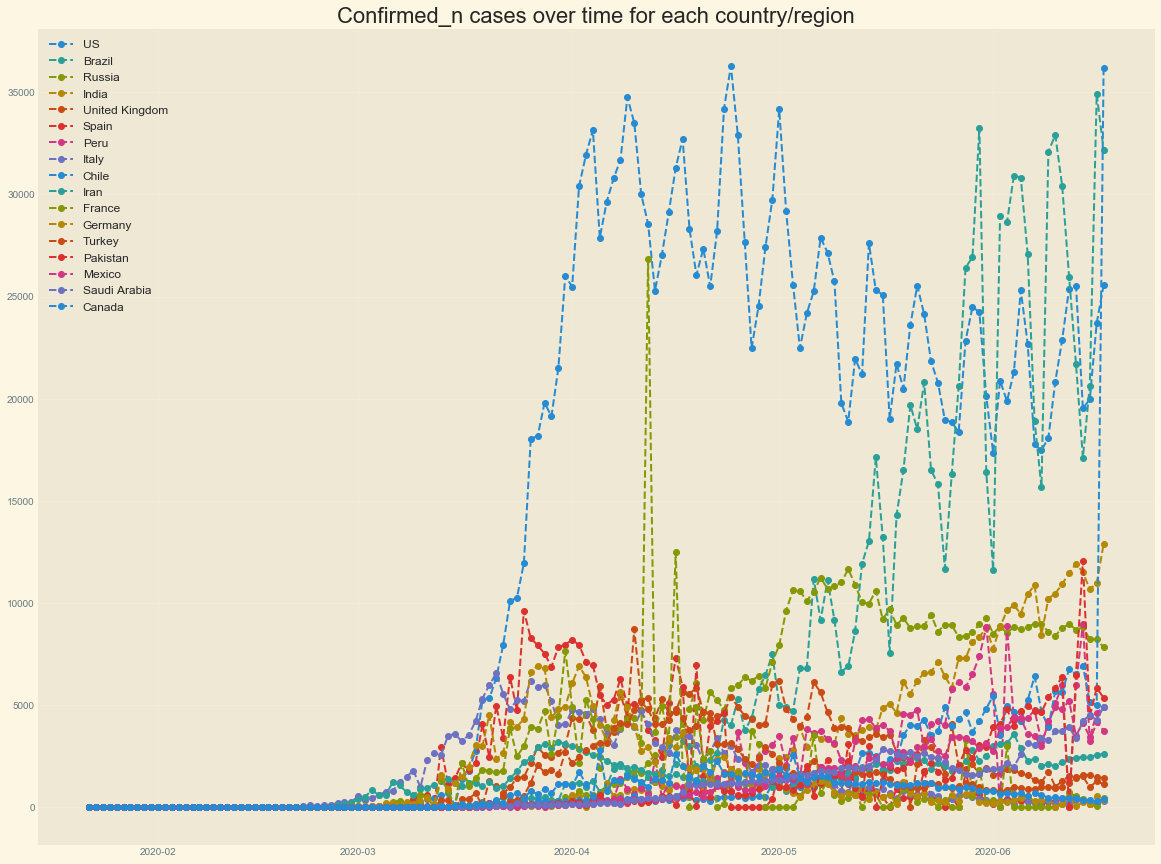

In [445]:
plot_overtime(df_affected,'Confirmed_n','Solarize_Light2')


In [446]:
World_Data[World_Data['Confirmed_n']<0]

Empty DataFrame
Columns: [Country, Date, Confirmed, Deaths, Recovered, Confirmed_n, Deaths_n, Recovered_n, Deathrate, Recoveryrate, Active, Active_n]
Index: []

<Figure size 1440x1080 with 0 Axes>

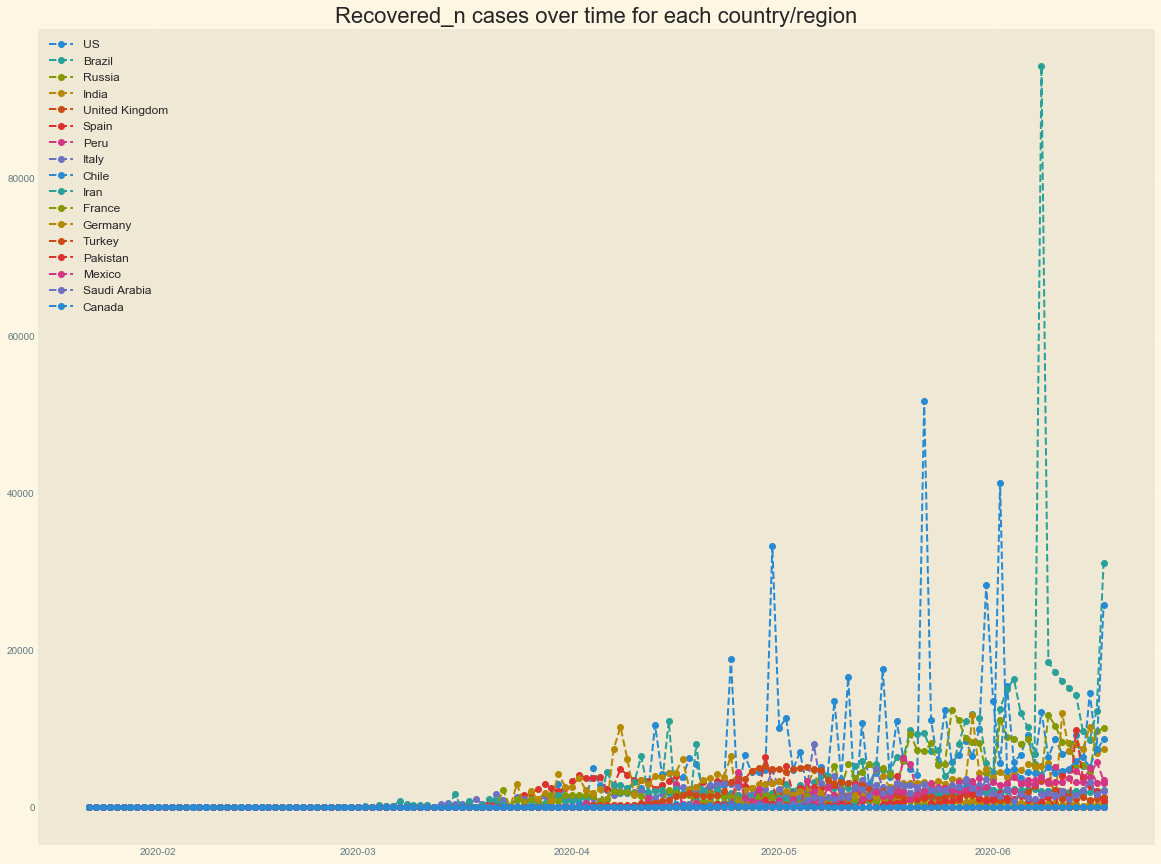

In [447]:
plot_overtime(df_affected,'Recovered_n','Solarize_Light2')

<Figure size 1440x1080 with 0 Axes>

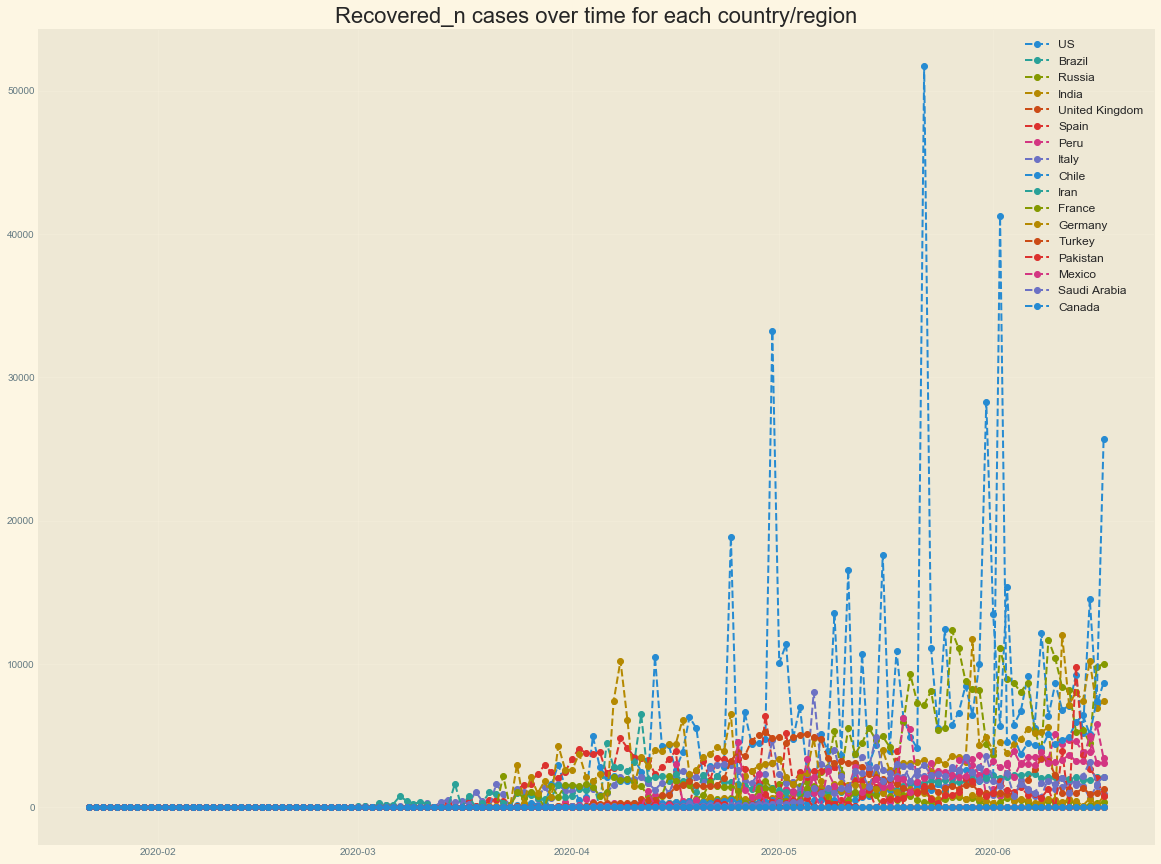

In [448]:
plot_overtime(df_affected[df_affected['Country']!='Brazil'],'Recovered_n','Solarize_Light2')

<Figure size 1440x1080 with 0 Axes>

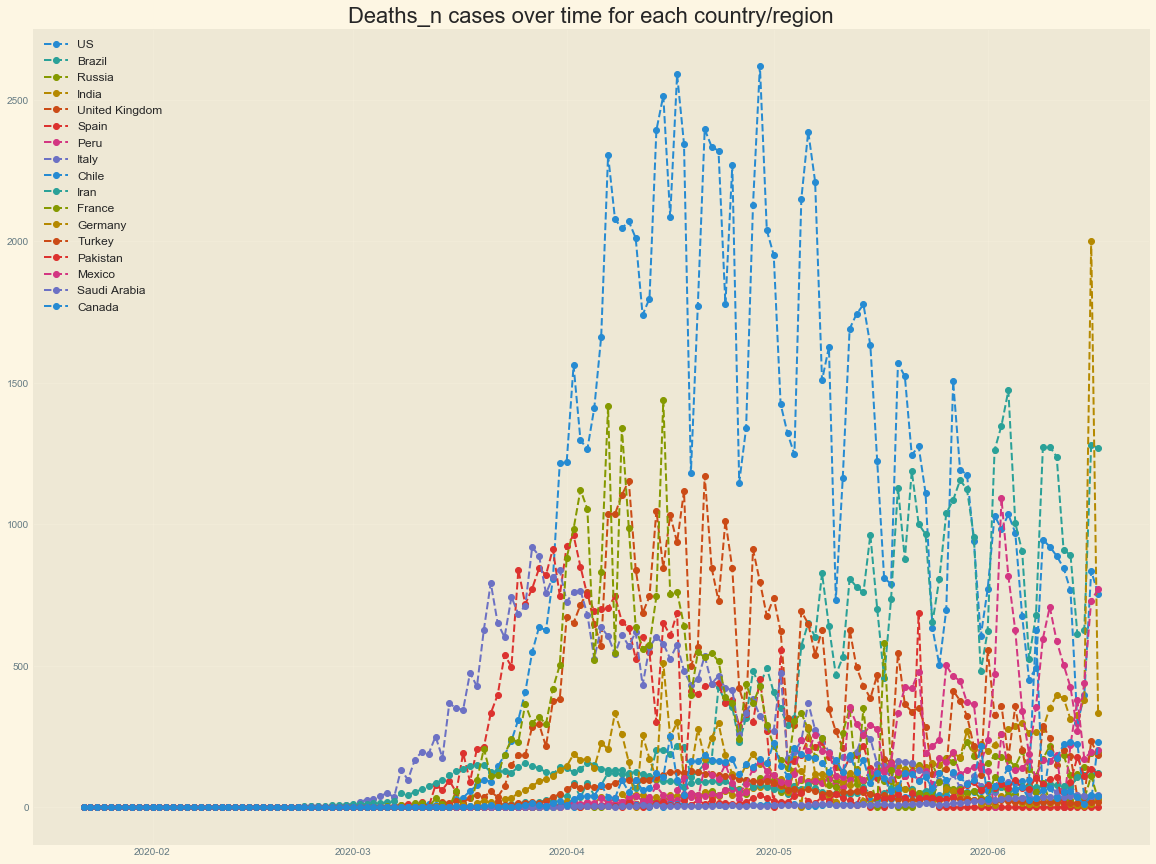

In [449]:
plot_overtime(df_affected,'Deaths_n','Solarize_Light2')

In [450]:
#times = df_affected['Date'].unique()
#times=df_affected['Date'].strftime('%Y-%m').unique()
#xlim=[df_affected['Date'].min(),df_affected['Date'].max()]
#ylim=[df_affected['Confirmed'].min(),df_affected['Confirmed'].max()]
#g = sns.FacetGrid(df_affected, col="Country", col_wrap=3,height=3)
#g = g.map(sns.barplot, "Date", "Confirmed",order=times)


Text(0.5, 1.0, 'Trend of Active,Death and Recovered cases in each country')

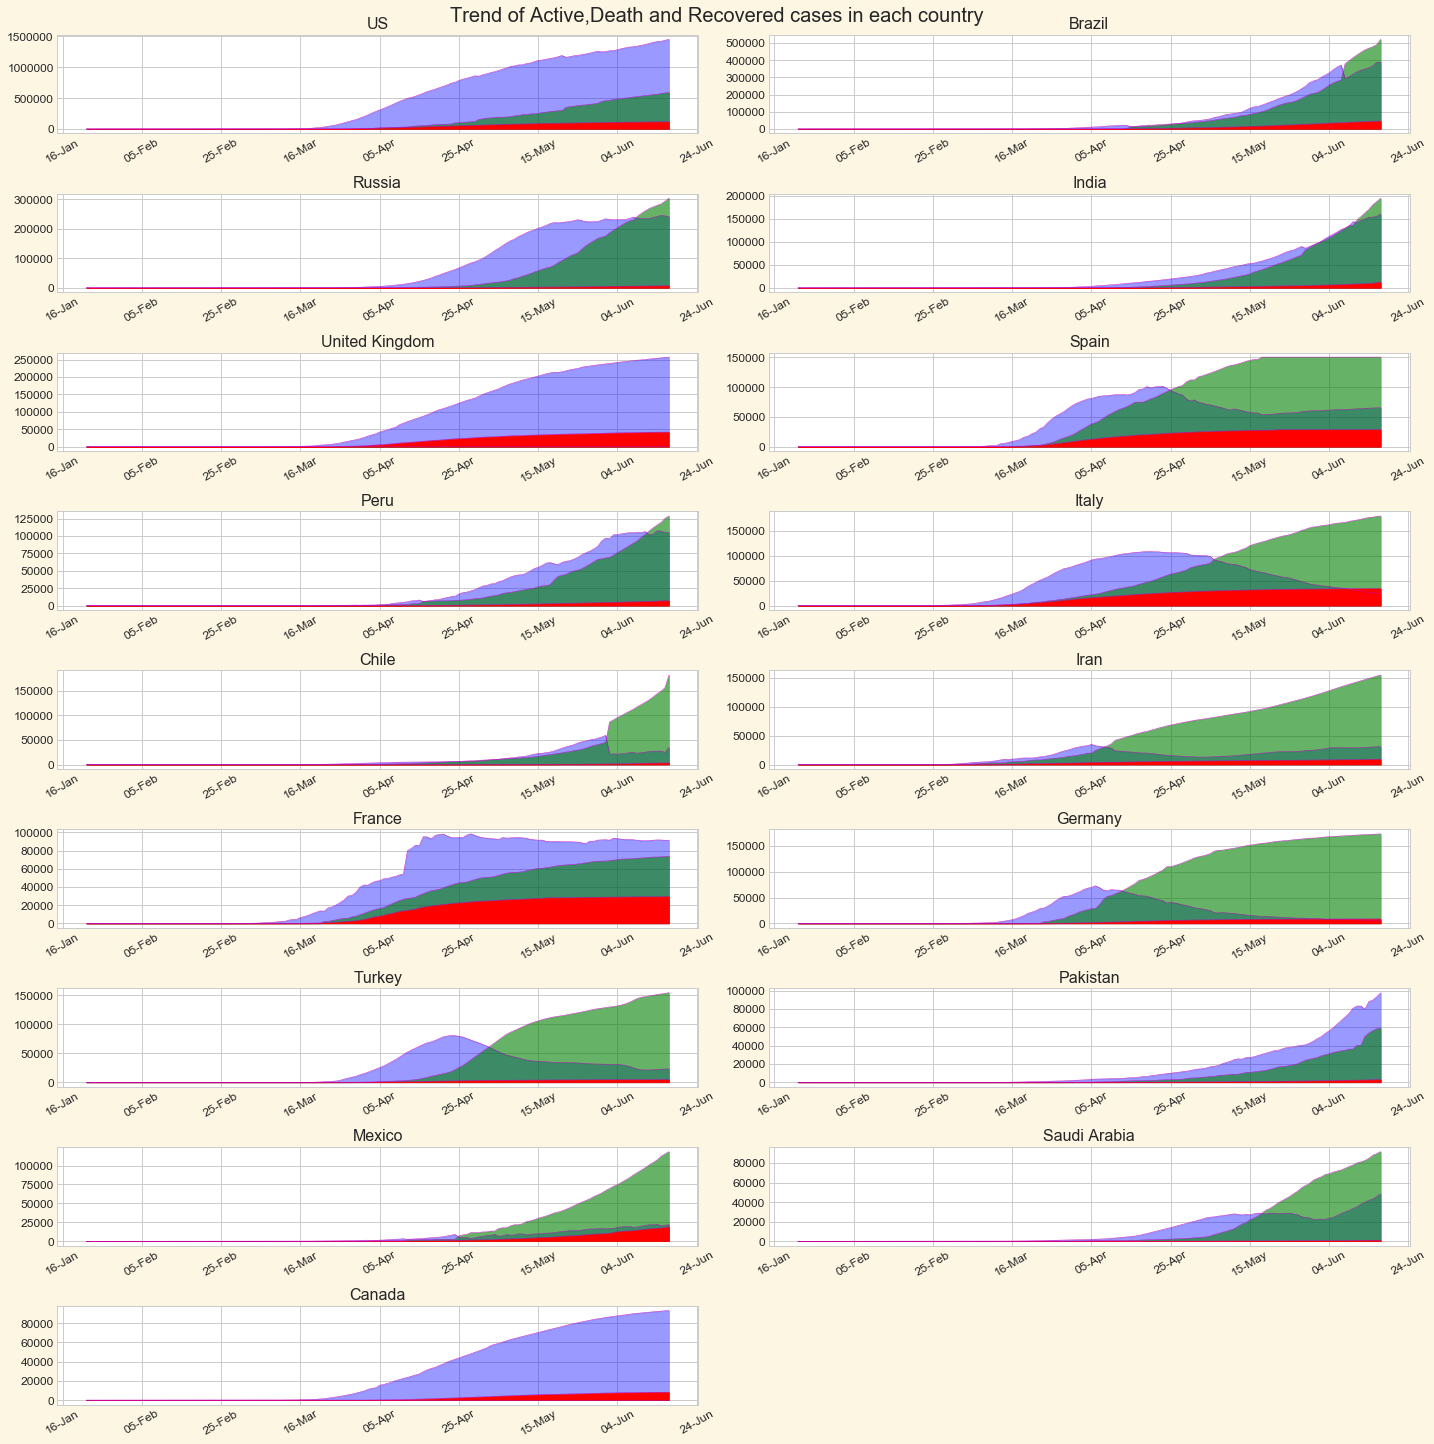

In [451]:
fig = plt.figure(figsize= (20,20))
plt.style.use('seaborn-whitegrid')

m= len(Affected)
max_rows=int((m+1)/2)
k=0
#fig,axs=plt.subplots(int(max_rows),2,figsize= (16,20),sharex=True,sharey=True)
for i,k in zip(Affected,range(1,m+1)):
    axs=fig.add_subplot(max_rows,2,k)
    df=df_affected[df_affected['Country']==i]
    axs.fill_between(df['Date'],df['Active'],color='blue',label = 'Active',alpha=0.4)
    axs.plot(df['Date'],df['Active'],color='m',linewidth=0.5,alpha=0.9)
    axs.fill_between(df['Date'],df['Recovered'],color='green',label='Recovered',alpha=0.6)
    axs.plot(df['Date'],df['Recovered'],color='m',linewidth=0.5,alpha=0.9)
    axs.fill_between(df['Date'],df['Deaths'],color='red',label='Deaths')
    axs.plot(df['Date'],df['Deaths'],color='m',linewidth=0.5,alpha=0.9)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=30,fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(i,fontsize=16)
    plt.locator_params(axis='y', nbins=6)
    axs.xaxis.set_major_locator(ticker.MultipleLocator(20))
    
    k=k+1
plt.tight_layout(pad=1)
plt.suptitle('Trend of Active,Death and Recovered cases in each country',fontsize = 20,y=1.0)


With this plot, we can observe the trend of active cases, recoveries and deaths in each country which gives an idea on whether recoveries are at an increasing pace or active cases are at an increasing pace. In Italy, Spain and Germany, recovery rate is much higher which is observed in previous plots also[recovery rate plot] and active cases rate is decreasing gradually. In contrast, US Active cases are increasing at a much higher rate than its recovery rate.India, Pakistan and Peru showed almost similar trend in active cases and recovery rate. This might be because of poor lockdown regulations in US resulting in exponential growth of active cases. Lets have a look at stacked chart indicating the proportion of active , recovered and death cases in each country.

Text(0.5, 1.0, 'Trend of new Confirmed,Death and Recovered cases in each country')

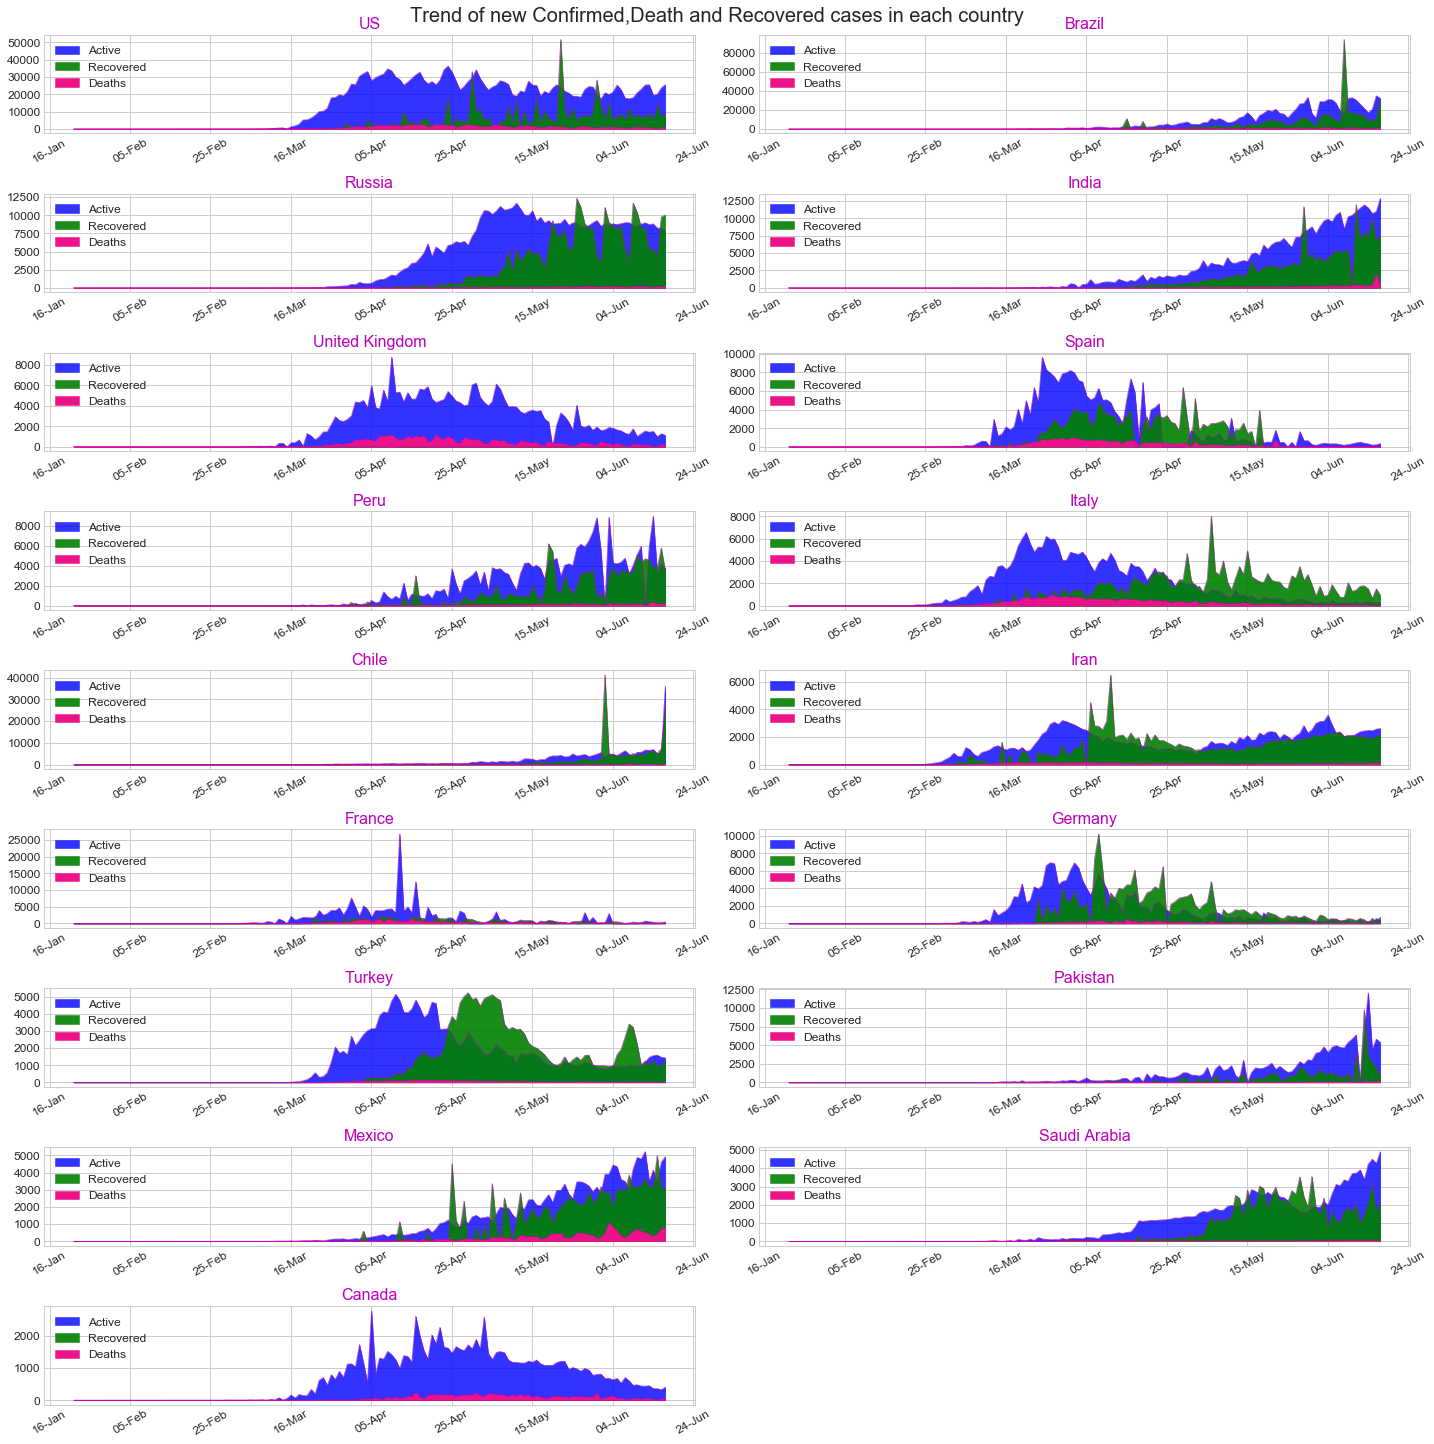

In [452]:
fig = plt.figure(figsize= (20,20))
plt.style.use('seaborn-whitegrid')

m= len(Affected)
max_rows=int((m+1)/2)
k=0
#fig,axs=plt.subplots(int(max_rows),2,figsize= (16,20),sharex=True,sharey=True)
for i,k in zip(Affected,range(1,m+1)):
    axs=fig.add_subplot(max_rows,2,k)
    df=df_affected[df_affected['Country']==i]
    axs.fill_between(df['Date'],df['Confirmed_n'],color='blue',label = 'Active',alpha=0.8)
    axs.plot(df['Date'],df['Confirmed_n'],color='m',linewidth=0.5,alpha=0.9)
    axs.fill_between(df['Date'],df['Recovered_n'],color='green',label='Recovered',alpha=0.9)
    axs.plot(df['Date'],df['Recovered_n'],color='m',linewidth=0.5,alpha=0.9)
    axs.fill_between(df['Date'],df['Deaths_n'],color='#EE1289',label='Deaths')
    axs.plot(df['Date'],df['Deaths_n'],color='m',linewidth=0.5,alpha=0.9)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=30,fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(i,fontsize=16,color='m')
    plt.locator_params(axis='y', nbins=6)
    axs.xaxis.set_major_locator(ticker.MultipleLocator(20))
    plt.legend(loc='upper left',fontsize=12)
    k=k+1
plt.tight_layout(pad=1)
plt.suptitle('Trend of new Confirmed,Death and Recovered cases in each country',fontsize = 20,y=1.0)


Text(0.5, 1.0, 'Trend of Active,Death and Recovered cases in each country[STACKED]')

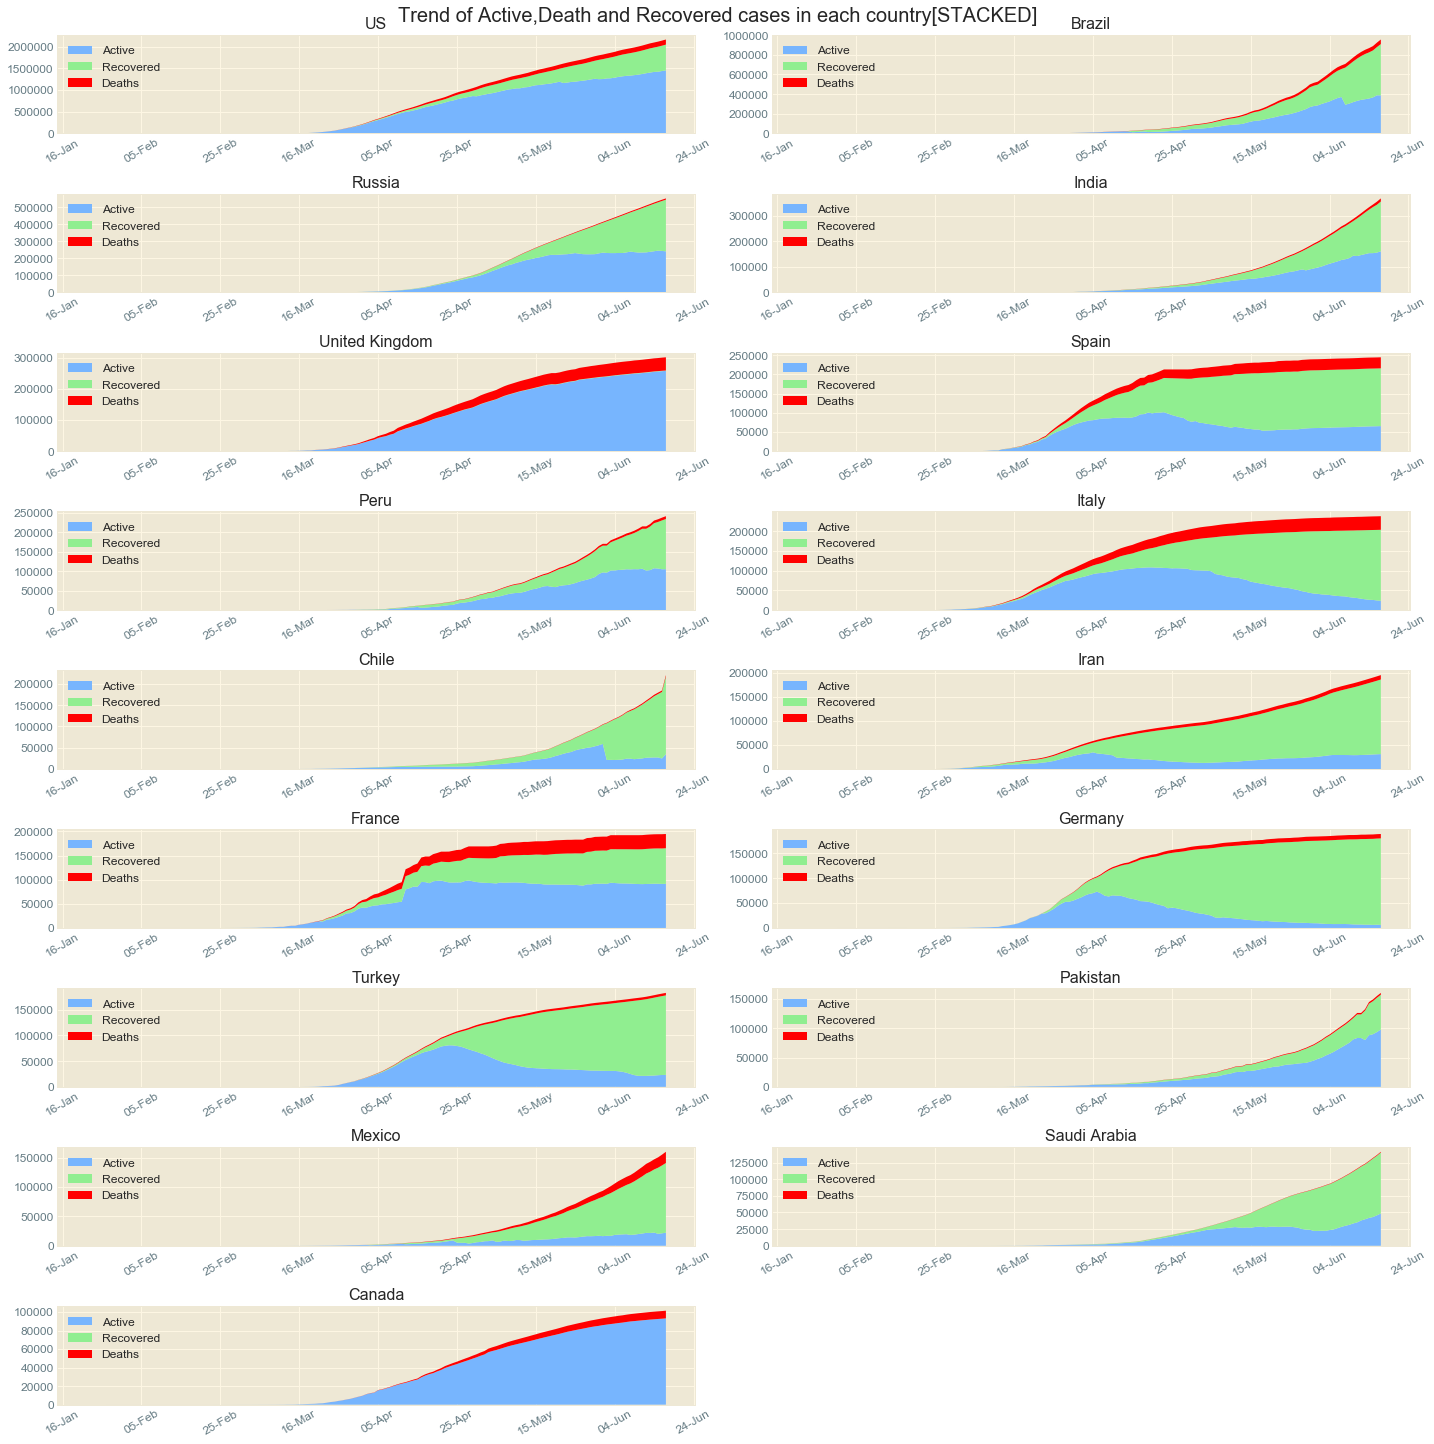

In [453]:
fig = plt.figure(figsize= (20,20))
plt.style.use('Solarize_Light2')

m= len(Affected)
max_rows=int((m+1)/2)
k=0
#fig,axs=plt.subplots(int(max_rows),2,figsize= (16,20),sharex=True,sharey=True)
for i,k in zip(Affected,range(1,m+1)):
    axs=fig.add_subplot(max_rows,2,k)
    df=df_affected[df_affected['Country']==i]
    color=['#77b5fe','#90EE90','r']
    axs.stackplot(df['Date'],df['Active'],df['Recovered'],df['Deaths'], labels=['Active','Recovered','Deaths'],colors=color)

    axs.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=30,fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(i,fontsize=16)
    plt.locator_params(axis='y', nbins=6)
    axs.xaxis.set_major_locator(ticker.MultipleLocator(20))
    plt.legend(loc='upper left',fontsize=12)
    k=k+1
plt.tight_layout(pad=1)
plt.suptitle('Trend of Active,Death and Recovered cases in each country[STACKED]',fontsize = 20,y=1.0)


As expected, Most of the countries have better recovered cases proportion and reduced active cases with time.But downward trend of active cases is not observed in some countries/regions like India,Pakistan and US.What could be possible reasons?- Number of tests done are not enough to find all existing cases? Strict lockdown is not implemented in those regions? How would be the case if there is no lockdown- exponential growth or different growth based on contacts ? Are we comparing regions just based on the confirmed cases, ignoring their population? 

In [454]:
url = 'https://www.worldometers.info/world-population/population-by-country'
html = requests.get(url).content
popu=pd.read_html(html)
population = popu[0]
population.rename(columns={'Country (or dependency)':'Country','Population (2020)':'Population'},inplace=True)
population.head()

#        Country  Population Yearly Change  Net Change  Density (P/Km²)  \
0  1          China  1439323776        0.39 %     5540090              153   
1  2          India  1380004385        0.99 %    13586631              464   
2  3  United States   331002651        0.59 %     1937734               36   
3  4      Indonesia   273523615        1.07 %     2898047              151   
4  5       Pakistan   220892340        2.00 %     4327022              287   

   Land Area (Km²)  Migrants (net) Fert. Rate Med. Age Urban Pop % World Share  
0          9388211       -348399.0        1.7       38        61 %     18.47 %  
1          2973190       -532687.0        2.2       28        35 %     17.70 %  
2          9147420        954806.0        1.8       38        83 %      4.25 %  
3          1811570        -98955.0        2.3       30        56 %      3.51 %  
4           770880       -233379.0        3.6       23        35 %      2.83 %

In [455]:
Data_r=Data_recent.copy()

Data_r= Data_r.join(population.set_index('Country')['Population'],on='Country')
Data_r[Data_r['Population'].isnull()]


Country       Date  Confirmed  Deaths  \
15391                        MS Zaandam 2020-06-17          9       2   
21015             Saint Kitts and Nevis 2020-06-17         15       0   
21311  Saint Vincent and the Grenadines 2020-06-17         29       0   
4143                              Burma 2020-06-17        262       6   
27083                West Bank and Gaza 2020-06-17        555       3   
21607             Sao Tome and Principe 2020-06-17        683      12   
7103                   Diamond Princess 2020-06-17        712      13   
13615                            Kosovo 2020-06-17       1486      33   
6067                      Cote d'Ivoire 2020-06-17       6063      48   
6659                            Czechia 2020-06-17      10162     333   
13467                      Korea, South 2020-06-17      12257     280   
25751                                US 2020-06-17    2163290  117717   

       Recovered  Confirmed_n  Deaths_n  Recovered_n  Deathrate  Recoveryrate  \
15391          0            0         0            0      22.22          0.00   
21015         15            0         0            0       0.00        100.00   
21311         25            0         0            0       0.00         86.21   
4143         185            0         0            6       2.29         70.61   
27083        415           41         0            0       0.54         74.77   
21607        188           12         0            6       1.76         27.53   
7103         651            0         0            0       1.83         91.43   
13615        953            0         0            0       2.22         64.13   
6067        2749          384         2          112       0.79         45.34   
6659        7399           51         2           41       3.28         72.81   
13467      10800           59         1           26       2.28         88.11   
25751     592191        25559       754         8688       5.44         27.37   

        Active  Active_n  Population  
15391        7         0         NaN  
21015        0         0         NaN  
21311        4         0         NaN  
4143        71        -6         NaN  
27083      137        41         NaN  
21607      483         6         NaN  
7103        48         0         NaN  
13615      500         0         NaN  
6067      3266       270         NaN  
6659      2430         8         NaN  
13467     1177        32         NaN  
25751  1453382     16117         NaN

In [456]:
Data_r.loc[Data_r['Country']=='US','Population']=population.loc[population['Country']=='United States','Population'].values
Data_r.loc[Data_r['Country']=='Korea, South','Population']=population.loc[population['Country']=='South Korea','Population'].values
Data_r.loc[Data_r['Country']=='Czechia','Population']=population.loc[population['Country']=='Czech Republic (Czechia)','Population'].values
Data_r.loc[Data_r['Country']=='Cote d\'Ivoire','Population']=population.loc[population['Country']=='Côte d\'Ivoire','Population'].values

Data_r.loc[Data_r['Country']=='Sao Tome and Principe','Population']=population.loc[population['Country']=='Sao Tome & Principe','Population'].values

Data_r.loc[Data_r['Country']=='Saint Kitts and Nevis','Population']=population.loc[population['Country']=='Saint Kitts & Nevis','Population'].values
Data_r.loc[Data_r['Country']=='Saint Vincent and the Grenadines','Population']=population.loc[population['Country']=='St. Vincent & Grenadines','Population'].values
Data_r.loc[Data_r['Country']=='Kosovo','Population']=1810366
Data_r.loc[Data_r['Country']=='Burma','Population']= 54409800
Data_r.loc[Data_r['Country']=='West Bank and Gaza','Population']=4570000

In [457]:
Data_r[Data_r['Population'].isnull()]


Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  \
15391        MS Zaandam 2020-06-17          9       2          0            0   
7103   Diamond Princess 2020-06-17        712      13        651            0   

       Deaths_n  Recovered_n  Deathrate  Recoveryrate  Active  Active_n  \
15391         0            0      22.22          0.00       7         0   
7103          0            0       1.83         91.43      48         0   

       Population  
15391         NaN  
7103          NaN

In [458]:
Data_r=Data_r.dropna(subset=['Population'])
Data_r[Data_r['Population'].isnull()]


Empty DataFrame
Columns: [Country, Date, Confirmed, Deaths, Recovered, Confirmed_n, Deaths_n, Recovered_n, Deathrate, Recoveryrate, Active, Active_n, Population]
Index: []

Cases as a percentage of population or cases per million population--normalization 

In [459]:
Data_r['Population']=Data_r['Population'].astype('int')
Data_r['Confirmed_perM']= round(Data_r['Confirmed']/Data_r['Population']*1000000,0).astype('int')
Data_r['Recovered_perM']= round(Data_r['Recovered']/Data_r['Population']*1000000,0).astype('int')
Data_r['Deaths_perM']= round(Data_r['Deaths']/Data_r['Population']*1000000,0).astype('int')
Data_r['Active_perM']= round(Data_r['Active']/Data_r['Population']*1000000,0).astype('int')

In [460]:
Most_affected_perM=Data_r.sort_values(by=['Confirmed_perM'],ascending=False).head(20)


From this data, its clear that the countries with high number of confirmed cases are not the same as countries with high number of confirmed cases per million. As per the number of confirmed cases, India stands in top 10 but we can say that the spread of COVID is much less than other countries based on population data. 


In [461]:
Most_affected_perM.sort_values(by=['Confirmed_perM'],ascending=False).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='Blues',subset=["Confirmed_n"])\
                        .background_gradient(cmap='Reds',subset=["Deaths_n"])\
                        .background_gradient(cmap='Greens',subset=["Recovered_n"])\
                        .background_gradient(cmap='YlOrBr',subset=["Active_n"])\
                        .background_gradient(cmap='spring',subset=["Deathrate"])\
                        .background_gradient(cmap='summer',subset=["Recoveryrate"])\
                        .background_gradient(cmap='Reds',subset=["Deaths_perM"])\
                        .background_gradient(cmap='Greens',subset=["Recovered_perM"])\
                        .background_gradient(cmap='Purples',subset=["Active_perM"])\
                        .background_gradient(cmap='Blues',subset=["Confirmed_perM"])\

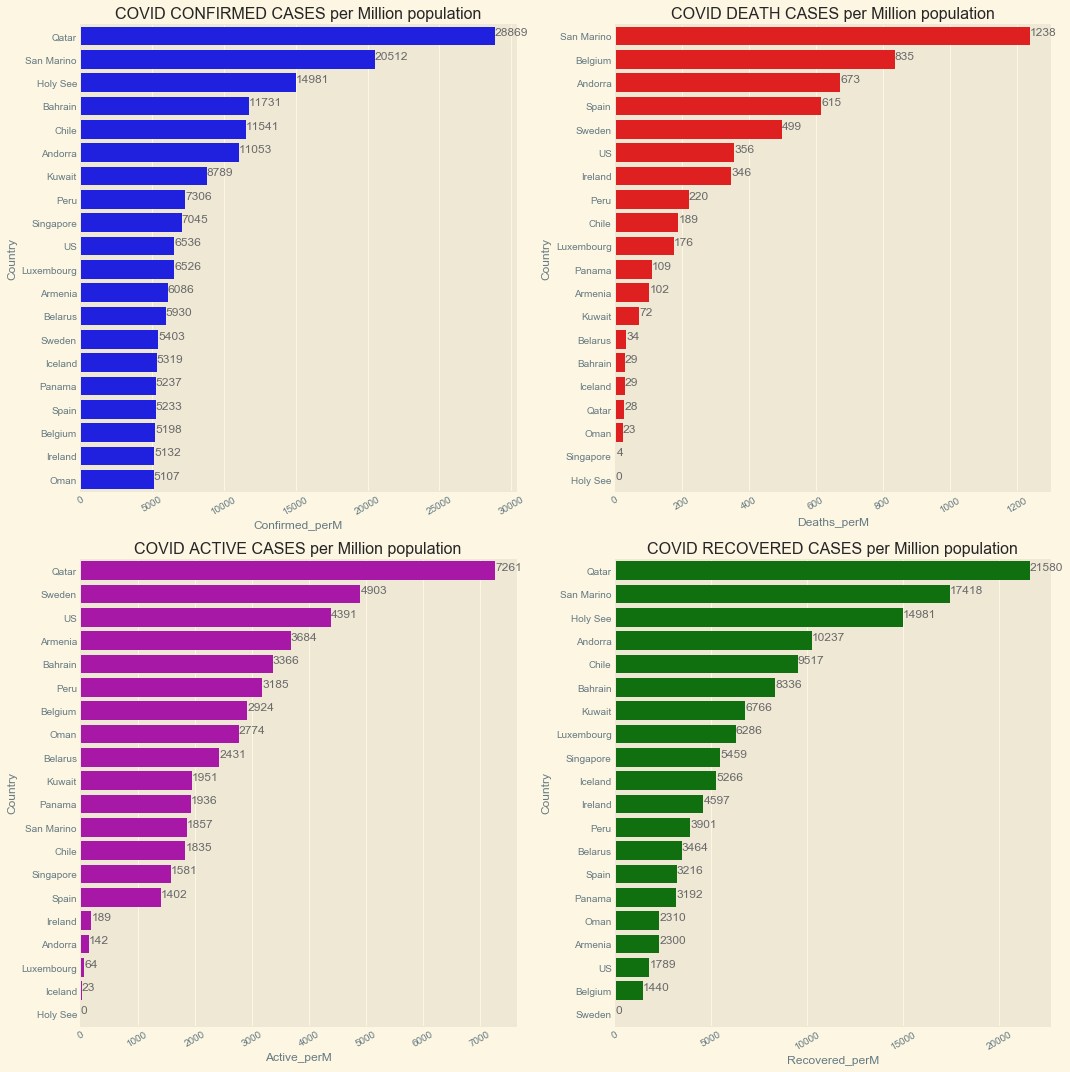

In [462]:
f, axes = plt.subplots(2, 2, figsize=(15, 15))

ax1=sns.barplot(x='Confirmed_perM',y='Country',data= Most_affected_perM.sort_values(by=['Confirmed_perM'],ascending=False),color='blue',ax=axes[0, 0])
plt.setp(axes[0,0].get_xticklabels(),visible=True, rotation=30)
ax1.set_title("COVID CONFIRMED CASES per Million population")
total_c=[]

for i in ax1.patches:
    ax1.text(i.get_width()+.3, i.get_y()+.38,int(i.get_width()), fontsize=12,color='dimgrey')

ax2=sns.barplot(x='Deaths_perM',y='Country',data= Most_affected_perM.sort_values(by=['Deaths_perM'],ascending=False),color='red',ax=axes[0, 1])
plt.setp(axes[0,1].get_xticklabels(), rotation=30)
ax2.set_title("COVID DEATH CASES per Million population")
total_c=[]

for i in ax2.patches:
    ax2.text(i.get_width()+.3, i.get_y()+.38,int(i.get_width()), fontsize=12,color='dimgrey')
ax3=sns.barplot(x='Active_perM',y='Country',data= Most_affected_perM.sort_values(by=['Active_perM'],ascending=False),color='m',ax=axes[1, 0])
plt.setp(axes[1,0].get_xticklabels(), rotation=30)
ax3.set_title("COVID ACTIVE CASES per Million population")
total_c=[]
#for i in ax3.patches:
#    total_c.append(i.get_width())
for i in ax3.patches:
    ax3.text(i.get_width()+.3, i.get_y()+.38,int(i.get_width()), fontsize=12,color='dimgrey')
ax4=sns.barplot(x='Recovered_perM',y='Country',data= Most_affected_perM.sort_values(by=['Recovered_perM'],ascending=False),color='green',ax=axes[1, 1])
plt.setp(axes[1,1].get_xticklabels(), rotation=30)

for i in ax4.patches:
    ax4.text(i.get_width()+.3, i.get_y()+.38,int(i.get_width()), fontsize=12,color='dimgrey')
ax4.set_title("COVID RECOVERED CASES per Million population")
plt.tight_layout()


In [467]:
!pip install folium
#import wget
#!wget --quiet https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/world_countries.json -O world_countries.json
import folium   
print('GeoJSON file downloaded!')
world_geo = r'world_countries.json' # geojson file

# create a plain world map

w= folium.Map(location=[0,0],tiles='Mapbox Bright')

w

GeoJSON file downloaded!


In [471]:
!pip install datapackage
from datapackage import Package

package = Package('https://datahub.io/core/geo-countries/datapackage.json')

# print list of all resources:
print(package.resource_names)

# print processed tabular data (if exists any)
for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        print(resource.read())

  Created wheel for linear-tsv: filename=linear_tsv-1.1.0-py3-none-any.whl size=7389 sha256=87cd789f2d7edf1849904c7995a35e5dccc049cf70a8a39627e3819f6032ca96
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\dd\0a\62\49ee84fab92057fb3e303fb1a59e75ccac6899b417f441305a
Successfully built linear-tsv
  Attempting uninstall: docutils
    Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16
['validation_report', 'geo-countries_zip', 'countries']


In [472]:
gg=open('https://datahub.io/core/geo-countries/datapackage.json')
f=json.load(gg)
f

OSError: [Errno 22] Invalid argument: 'https://datahub.io/core/geo-countries/datapackage.json'